In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

2025-05-28 16:27:24.783645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748449644.983376      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748449645.044183      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def train_phase(phase_path, sample=False, epochs=50, batch_size=32):
    best_model = None
    best_score = 0
    all_metrics = []

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")

        if sample:
            scaler = joblib.load(f"{fold_path}/scaler.pkl")
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            scaler = RobustScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        num_classes = len(np.unique(y_train))
        y_train_cat = to_categorical(y_train, num_classes=num_classes)
        y_val_cat = to_categorical(y_val, num_classes=num_classes)

        X_train_reshaped = np.expand_dims(X_train.values, axis=2)
        X_val_reshaped = np.expand_dims(X_val.values, axis=2)

        model = build_cnn_model(input_shape=X_train_reshaped.shape[1:], num_classes=num_classes)

        early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        model.fit(X_train_reshaped, y_train_cat, validation_data=(X_val_reshaped, y_val_cat),
                  epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])

        y_pred_probs = model.predict(X_val_reshaped)
        y_pred = np.argmax(y_pred_probs, axis=1)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(to_categorical(y_val), y_pred_probs, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(to_categorical(y_val)[:, i], y_pred_probs[:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics



======= Training Phase 1 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748449657.595820      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748449657.596610      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1748449662.012133      63 service.cc:148] XLA service 0x7fbdec0038f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748449662.012597      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748449662.012632      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748449662.401678      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/340 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5186 - loss: 1.6527

I0000 00:00:1748449665.814522      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6029 - loss: 1.2413 - val_accuracy: 0.6715 - val_loss: 0.8924
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6631 - loss: 0.8796 - val_accuracy: 0.6770 - val_loss: 0.8047
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6668 - loss: 0.8443 - val_accuracy: 0.6807 - val_loss: 0.7752
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6749 - loss: 0.8194 - val_accuracy: 0.6855 - val_loss: 0.7598
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6868 - loss: 0.7972 - val_accuracy: 0.6976 - val_loss: 0.7509
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6746 - loss: 0.8098 - val_accuracy: 0.6921 - val_loss: 0.7507
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6860 - loss: 0.7853 - val_accuracy: 0.7017 - val_loss: 0.7521
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6911 - loss: 0.7795 - val_accuracy: 0.6991 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


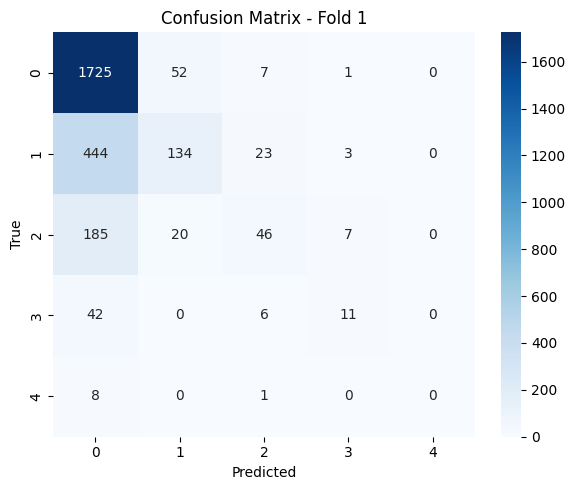

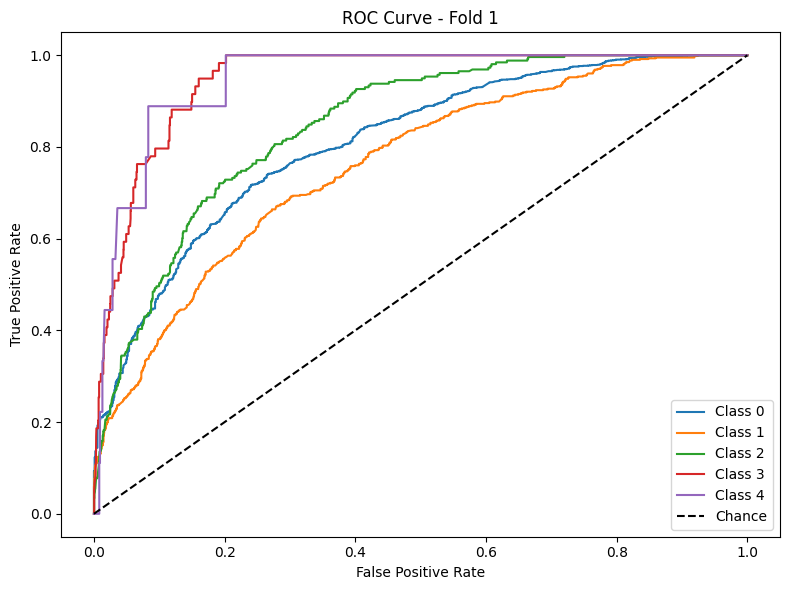

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6133 - loss: 1.1952 - val_accuracy: 0.6680 - val_loss: 0.8976
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6553 - loss: 0.8932 - val_accuracy: 0.6769 - val_loss: 0.8144
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6613 - loss: 0.8427 - val_accuracy: 0.6894 - val_loss: 0.7949
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6686 - loss: 0.8221 - val_accuracy: 0.6901 - val_loss: 0.7754
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6815 - loss: 0.8022 - val_accuracy: 0.6942 - val_loss: 0.7606
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6876 - loss: 0.7865 - val_accuracy: 0.6971 - val_loss: 0.7542
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6853 - loss: 0.7811 - val_accuracy: 0.6938 - val_loss: 0.7598
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6857 - loss: 0.7768 - val_accuracy: 0.6960 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


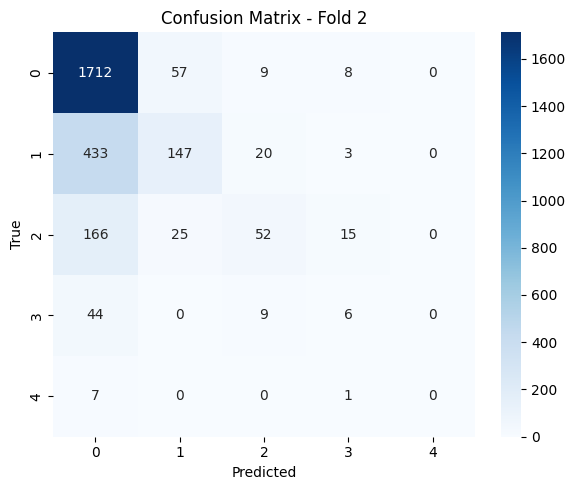

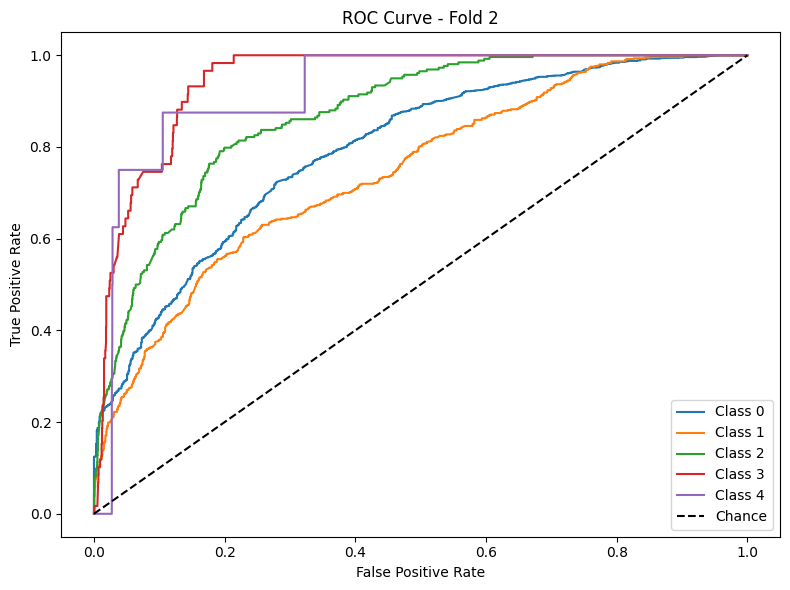

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6190 - loss: 1.2376 - val_accuracy: 0.6728 - val_loss: 0.8865
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6570 - loss: 0.8748 - val_accuracy: 0.6824 - val_loss: 0.8057
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6700 - loss: 0.8505 - val_accuracy: 0.6861 - val_loss: 0.7798
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6723 - loss: 0.8310 - val_accuracy: 0.6835 - val_loss: 0.7753
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6807 - loss: 0.8155 - val_accuracy: 0.6835 - val_loss: 0.7549
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6803 - loss: 0.7947 - val_accuracy: 0.6927 - val_loss: 0.7610
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6803 - loss: 0.7890 - val_accuracy: 0.6949 - val_loss: 0.7527
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6828 - loss: 0.7911 - val_accuracy: 0.7001 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


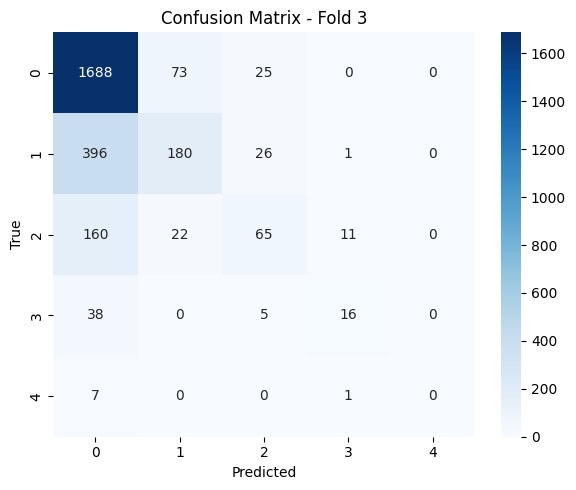

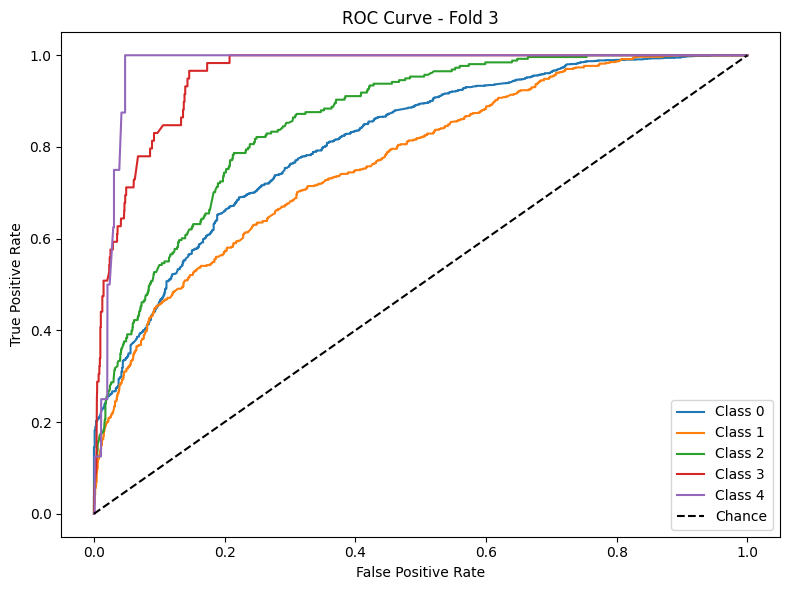

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5999 - loss: 1.2907 - val_accuracy: 0.6688 - val_loss: 0.9042
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6616 - loss: 0.8975 - val_accuracy: 0.6724 - val_loss: 0.8155
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6682 - loss: 0.8563 - val_accuracy: 0.6894 - val_loss: 0.7989
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6647 - loss: 0.8340 - val_accuracy: 0.6986 - val_loss: 0.7718
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6809 - loss: 0.7999 - val_accuracy: 0.6997 - val_loss: 0.7816
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6730 - loss: 0.8327 - val_accuracy: 0.7015 - val_loss: 0.7735
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6758 - loss: 0.8052 - val_accuracy: 0.7078 - val_loss: 0.7426
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6801 - loss: 0.8047 - val_accuracy: 0.7130 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


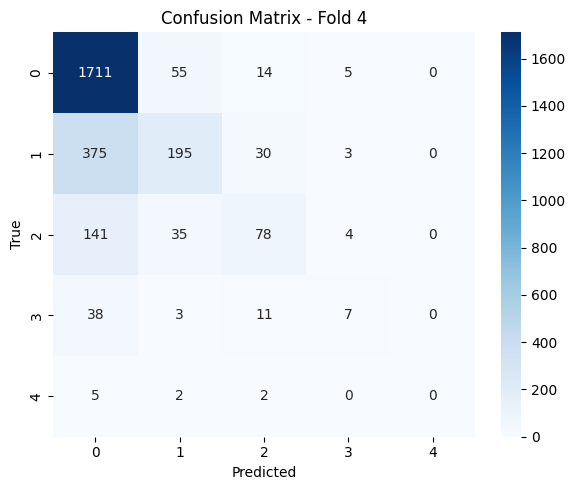

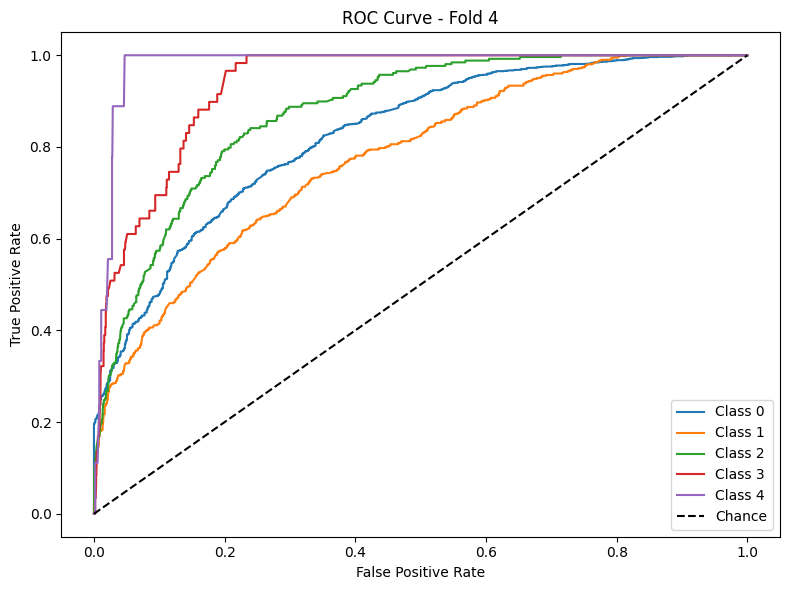

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6151 - loss: 1.2325 - val_accuracy: 0.6662 - val_loss: 0.8950
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6521 - loss: 0.9088 - val_accuracy: 0.6857 - val_loss: 0.8085
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6723 - loss: 0.8592 - val_accuracy: 0.6901 - val_loss: 0.7833
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6793 - loss: 0.8231 - val_accuracy: 0.6968 - val_loss: 0.7670
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6821 - loss: 0.7976 - val_accuracy: 0.6920 - val_loss: 0.7533
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6881 - loss: 0.7824 - val_accuracy: 0.6971 - val_loss: 0.7456
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6833 - loss: 0.7845 - val_accuracy: 0.7012 - val_loss: 0.7337
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6914 - loss: 0.7674 - val_accuracy: 0.7015 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


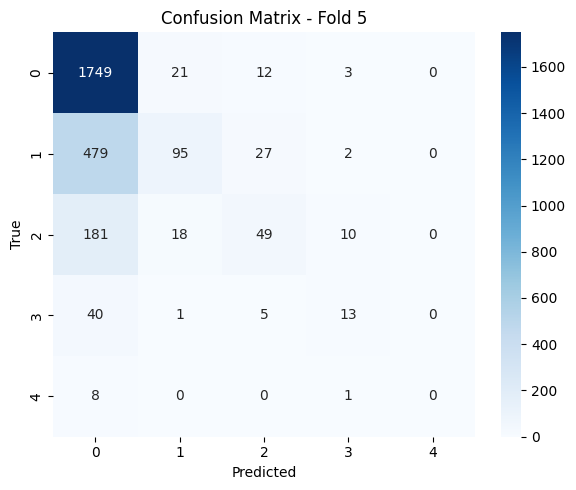

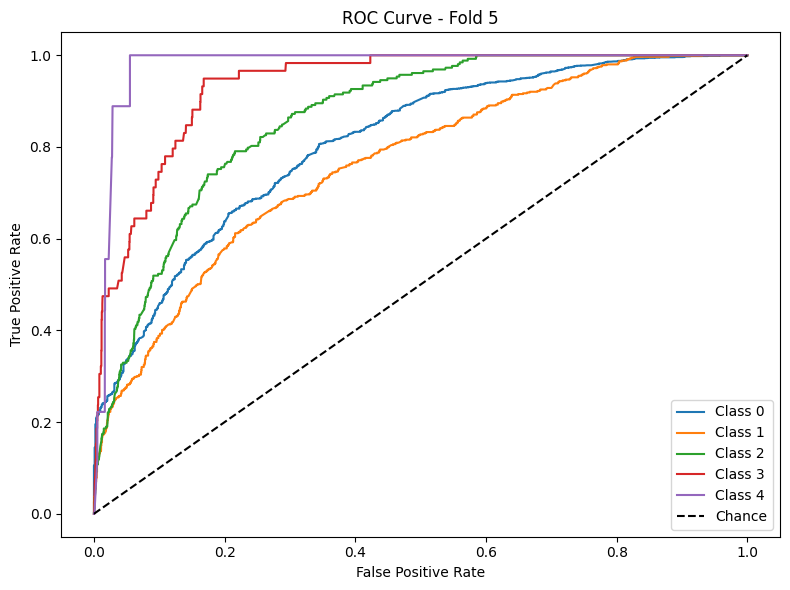


Average Accuracy: 0.7132
Average F1 Macro: 0.3505
Average AUC: 0.8681


======= Training Phase 2 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6147 - loss: 1.4528 - val_accuracy: 0.6597 - val_loss: 0.9515
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6559 - loss: 0.9126 - val_accuracy: 0.6571 - val_loss: 0.8757
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6591 - loss: 0.8443 - val_accuracy: 0.6655 - val_loss: 0.8057
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6589 - loss: 0.8376 - val_accuracy: 0.6761 - val_loss: 0.7991
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6698 - loss: 0.8325 - val_accuracy: 0.6801 - val_loss: 0.7720
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6809 - loss: 0.8131 - val_accuracy: 0.6770 - val_loss: 0.7783
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6719 - loss: 0.8113 - val_accuracy: 0.6858 - val_loss: 0.7610
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6748 - loss: 0.7900 - val_accuracy: 0.6881 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


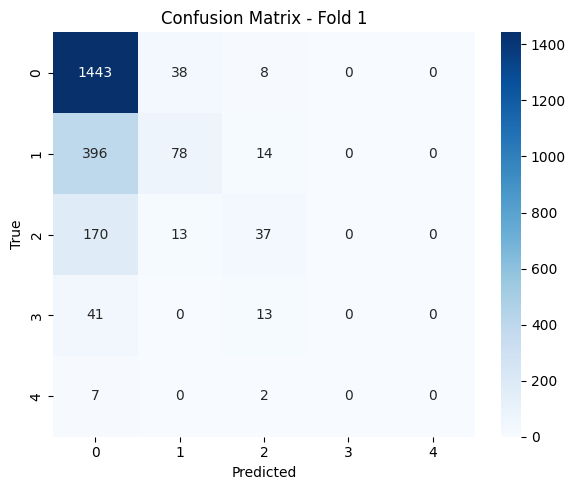

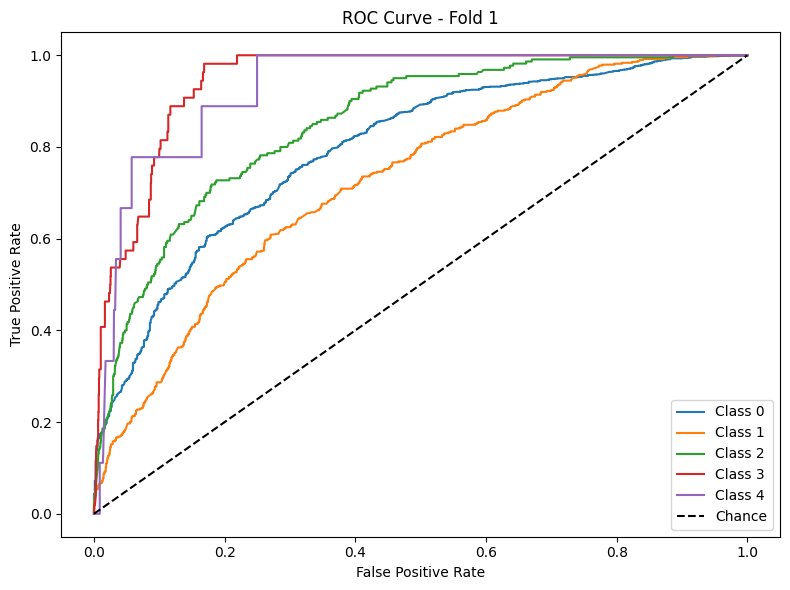

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5840 - loss: 1.4880 - val_accuracy: 0.6571 - val_loss: 0.9326
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6547 - loss: 0.9192 - val_accuracy: 0.6681 - val_loss: 0.8291
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6584 - loss: 0.8818 - val_accuracy: 0.6717 - val_loss: 0.7924
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6600 - loss: 0.8477 - val_accuracy: 0.6832 - val_loss: 0.7832
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6657 - loss: 0.8495 - val_accuracy: 0.6872 - val_loss: 0.7783
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6682 - loss: 0.8335 - val_accuracy: 0.6854 - val_loss: 0.7614
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6751 - loss: 0.8086 - val_accuracy: 0.6735 - val_loss: 0.7588
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6778 - loss: 0.8088 - val_accuracy: 0.6858 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


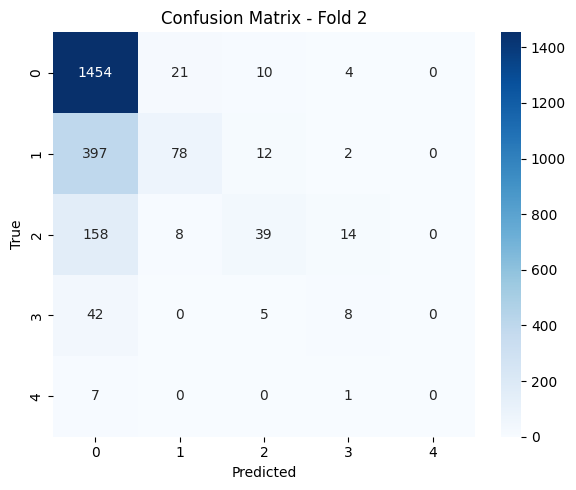

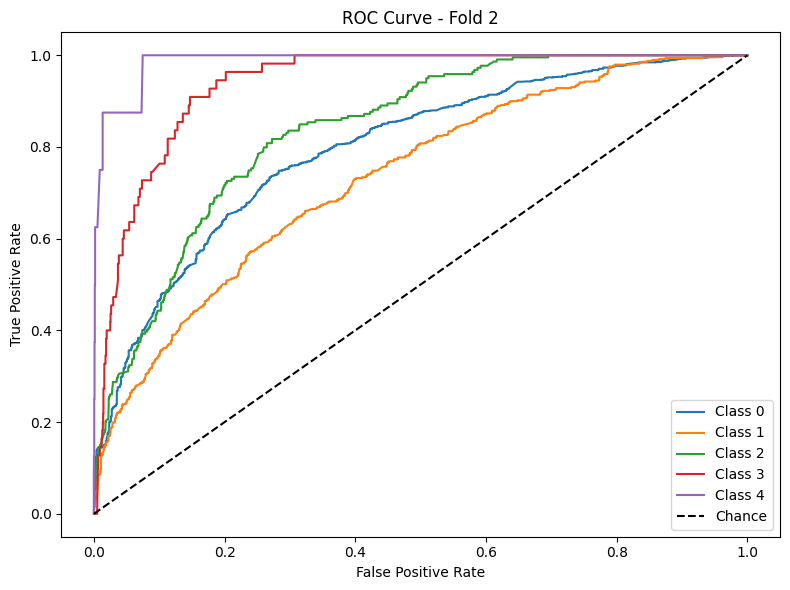

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6132 - loss: 1.3707 - val_accuracy: 0.6228 - val_loss: 1.0106
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6505 - loss: 0.9589 - val_accuracy: 0.6583 - val_loss: 0.8370
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6557 - loss: 0.8678 - val_accuracy: 0.6729 - val_loss: 0.8125
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6671 - loss: 0.8622 - val_accuracy: 0.6702 - val_loss: 0.8130
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6770 - loss: 0.8607 - val_accuracy: 0.6693 - val_loss: 0.7852
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6750 - loss: 0.8152 - val_accuracy: 0.6764 - val_loss: 0.8031
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6640 - loss: 0.8354 - val_accuracy: 0.6746 - val_loss: 0.7930
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6640 - loss: 0.8179 - val_accuracy: 0.6888 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


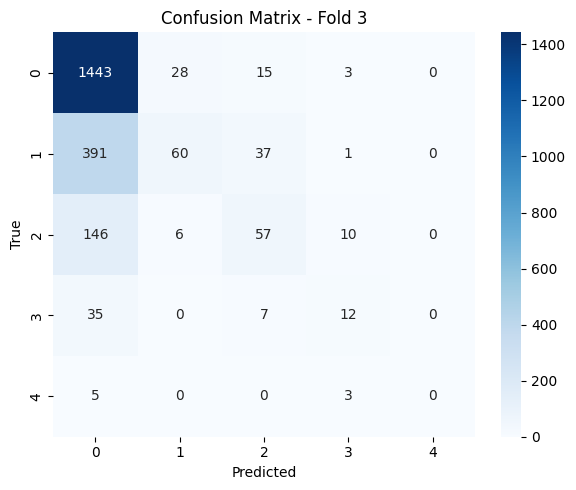

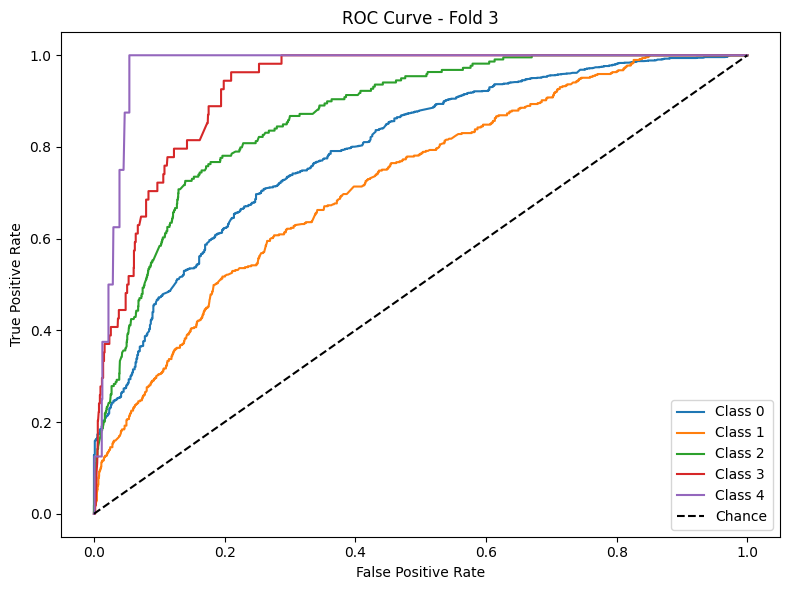

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6055 - loss: 1.3963 - val_accuracy: 0.6463 - val_loss: 0.9437
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6567 - loss: 0.9367 - val_accuracy: 0.6605 - val_loss: 0.8504
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6530 - loss: 0.8881 - val_accuracy: 0.6791 - val_loss: 0.8047
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6565 - loss: 0.8544 - val_accuracy: 0.6875 - val_loss: 0.7867
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6717 - loss: 0.8381 - val_accuracy: 0.6848 - val_loss: 0.7744
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6707 - loss: 0.8158 - val_accuracy: 0.6839 - val_loss: 0.7650
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6811 - loss: 0.7913 - val_accuracy: 0.6968 - val_loss: 0.7562
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6738 - loss: 0.7956 - val_accuracy: 0.6879 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


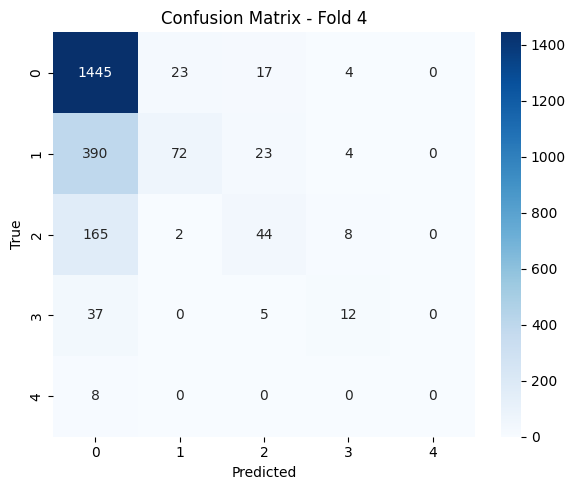

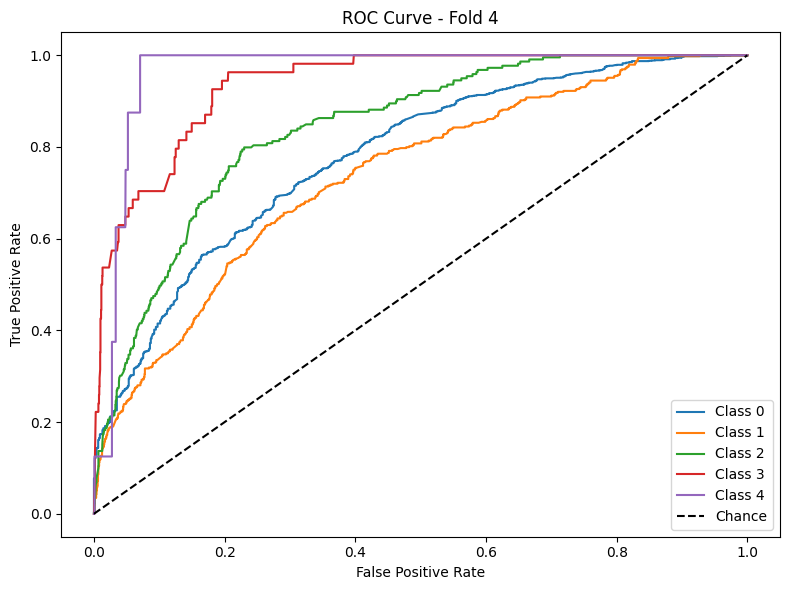

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6102 - loss: 1.3763 - val_accuracy: 0.6512 - val_loss: 0.9561
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6576 - loss: 0.9307 - val_accuracy: 0.6618 - val_loss: 0.8509
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6674 - loss: 0.8738 - val_accuracy: 0.6737 - val_loss: 0.8087
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6634 - loss: 0.8459 - val_accuracy: 0.6822 - val_loss: 0.7978
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6690 - loss: 0.8295 - val_accuracy: 0.6875 - val_loss: 0.7854
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6676 - loss: 0.8239 - val_accuracy: 0.6861 - val_loss: 0.7799
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6722 - loss: 0.8202 - val_accuracy: 0.6906 - val_loss: 0.7723
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6816 - loss: 0.8032 - val_accuracy: 0.6928 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


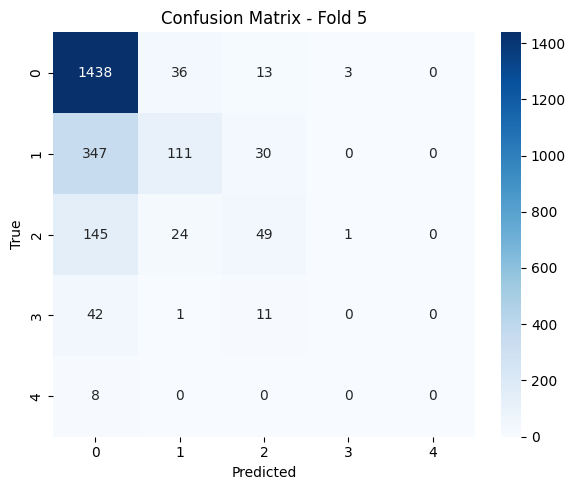

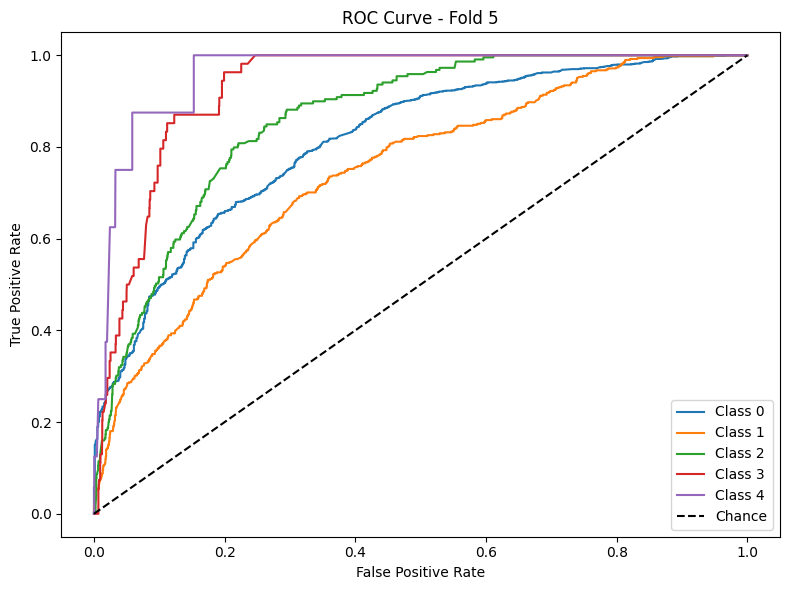


Average Accuracy: 0.6975
Average F1 Macro: 0.3053
Average AUC: 0.8560


======= Training Phase 3 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5999 - loss: 1.3867 - val_accuracy: 0.6461 - val_loss: 0.9560
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6504 - loss: 0.9235 - val_accuracy: 0.6635 - val_loss: 0.8553
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6526 - loss: 0.8747 - val_accuracy: 0.6716 - val_loss: 0.7935
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6530 - loss: 0.8437 - val_accuracy: 0.6823 - val_loss: 0.7774
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6733 - loss: 0.8174 - val_accuracy: 0.6731 - val_loss: 0.7790
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6691 - loss: 0.8256 - val_accuracy: 0.6789 - val_loss: 0.7638
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6765 - loss: 0.7958 - val_accuracy: 0.6760 - val_loss: 0.7594
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6611 - loss: 0.8186 - val_accuracy: 0.6779 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


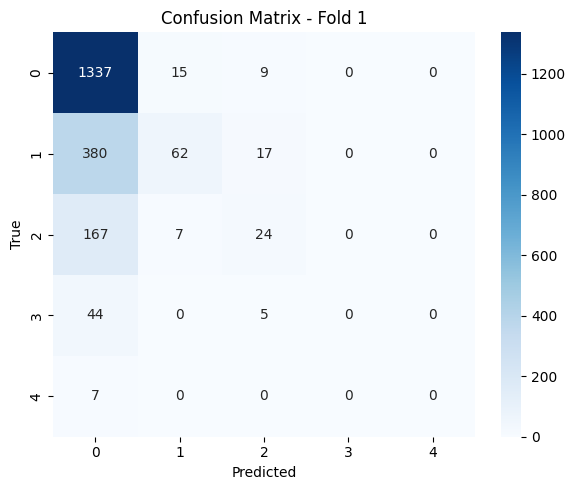

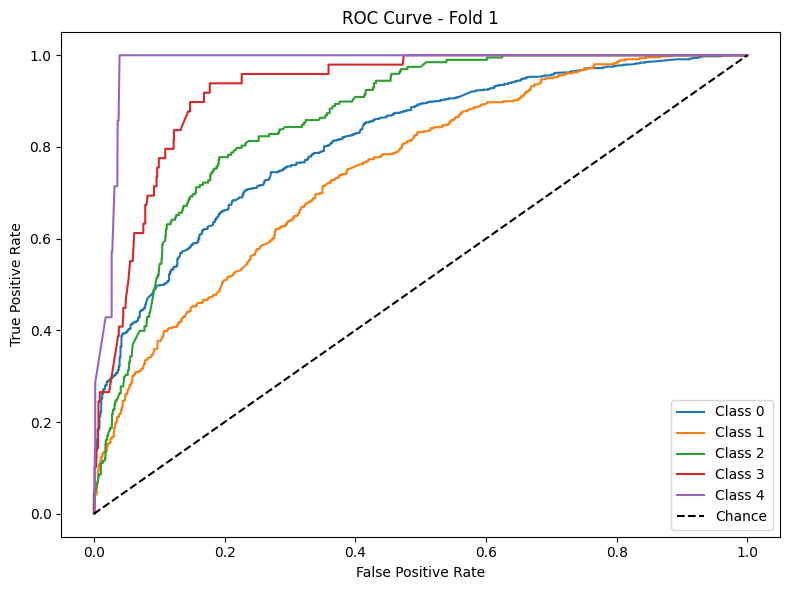

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6228 - loss: 1.4638 - val_accuracy: 0.6196 - val_loss: 1.0088
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6440 - loss: 0.9868 - val_accuracy: 0.6586 - val_loss: 0.8665
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6597 - loss: 0.8867 - val_accuracy: 0.6779 - val_loss: 0.8252
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6683 - loss: 0.8537 - val_accuracy: 0.6736 - val_loss: 0.7998
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6706 - loss: 0.8382 - val_accuracy: 0.6924 - val_loss: 0.7746
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6694 - loss: 0.8356 - val_accuracy: 0.6982 - val_loss: 0.7550
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6814 - loss: 0.8131 - val_accuracy: 0.6967 - val_loss: 0.7548
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6684 - loss: 0.8250 - val_accuracy: 0.6890 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


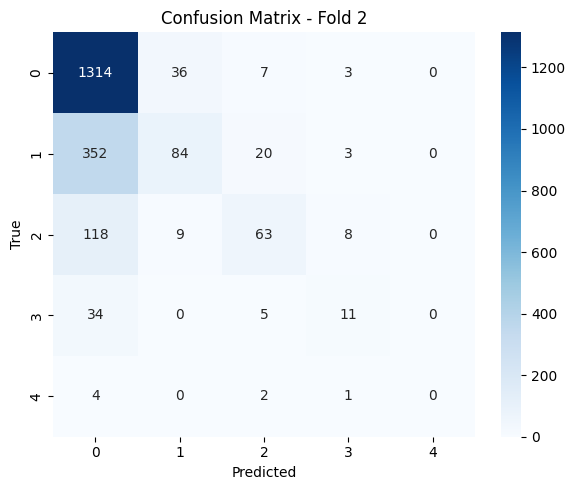

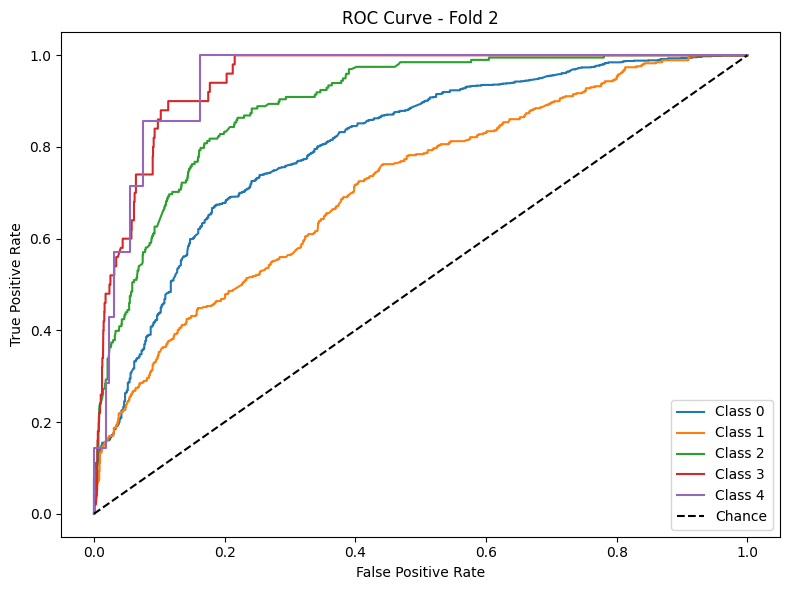

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5868 - loss: 1.5634 - val_accuracy: 0.6490 - val_loss: 0.9701
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6610 - loss: 0.9404 - val_accuracy: 0.6577 - val_loss: 0.8678
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6576 - loss: 0.8897 - val_accuracy: 0.6726 - val_loss: 0.8461
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6568 - loss: 0.8754 - val_accuracy: 0.6818 - val_loss: 0.8132
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6728 - loss: 0.8576 - val_accuracy: 0.6842 - val_loss: 0.7962
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6719 - loss: 0.8327 - val_accuracy: 0.6866 - val_loss: 0.7836
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6677 - loss: 0.8132 - val_accuracy: 0.6823 - val_loss: 0.7825
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6782 - loss: 0.8117 - val_accuracy: 0.6895 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


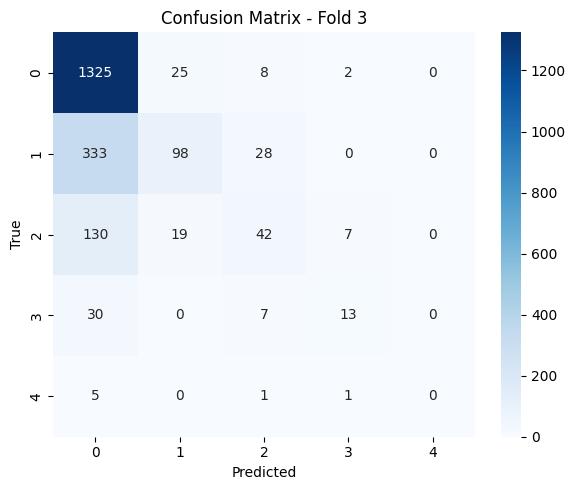

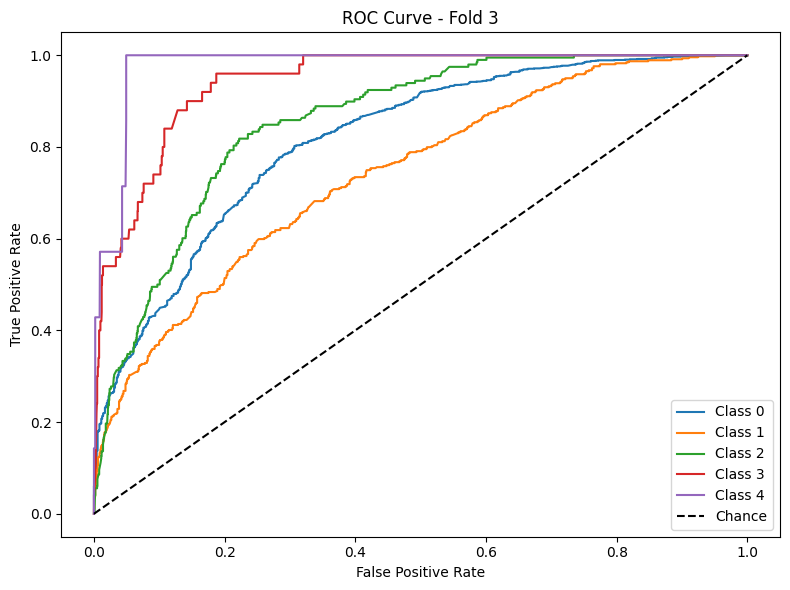

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6017 - loss: 1.3643 - val_accuracy: 0.6490 - val_loss: 0.9699
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6542 - loss: 0.9296 - val_accuracy: 0.6528 - val_loss: 0.8839
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6690 - loss: 0.8690 - val_accuracy: 0.6678 - val_loss: 0.8190
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6789 - loss: 0.8373 - val_accuracy: 0.6716 - val_loss: 0.7999
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6606 - loss: 0.8390 - val_accuracy: 0.6818 - val_loss: 0.7945
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6742 - loss: 0.8399 - val_accuracy: 0.6803 - val_loss: 0.7894
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6780 - loss: 0.7951 - val_accuracy: 0.6832 - val_loss: 0.7750
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6734 - loss: 0.8054 - val_accuracy: 0.6818 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


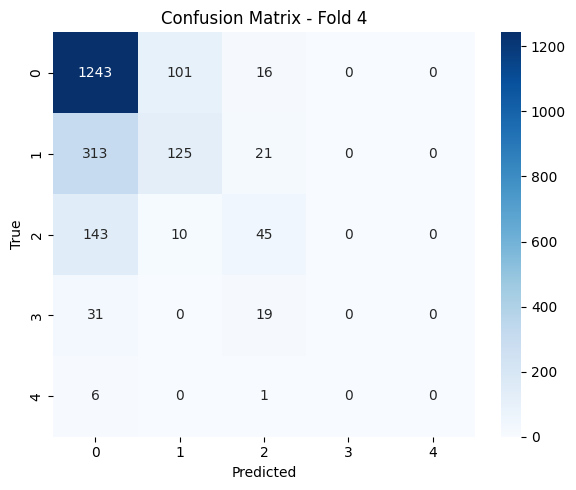

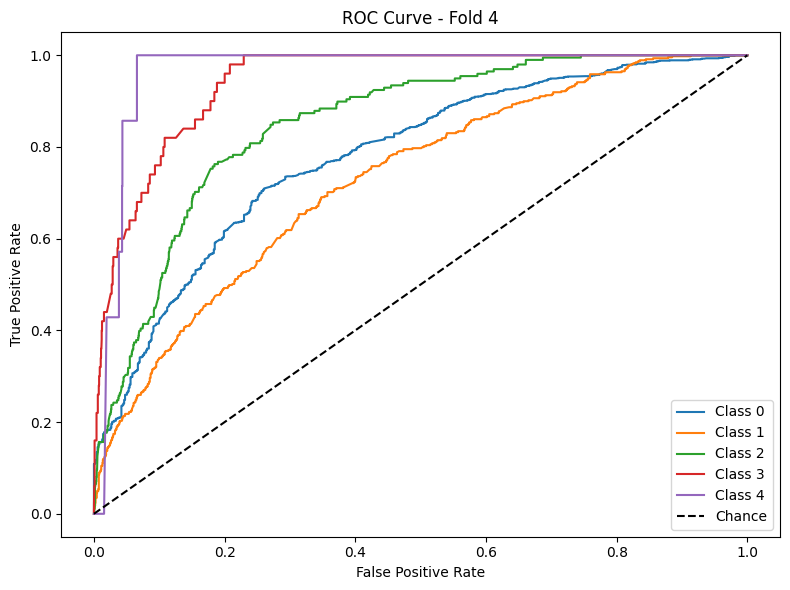

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5996 - loss: 1.4594 - val_accuracy: 0.6556 - val_loss: 0.9780
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6402 - loss: 0.9792 - val_accuracy: 0.6565 - val_loss: 0.8616
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6571 - loss: 0.8769 - val_accuracy: 0.6696 - val_loss: 0.8249
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6733 - loss: 0.8358 - val_accuracy: 0.6763 - val_loss: 0.8033
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6694 - loss: 0.8197 - val_accuracy: 0.6773 - val_loss: 0.7877
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6708 - loss: 0.8148 - val_accuracy: 0.6845 - val_loss: 0.7879
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6862 - loss: 0.7869 - val_accuracy: 0.6855 - val_loss: 0.7925
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6705 - loss: 0.8006 - val_accuracy: 0.6855 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


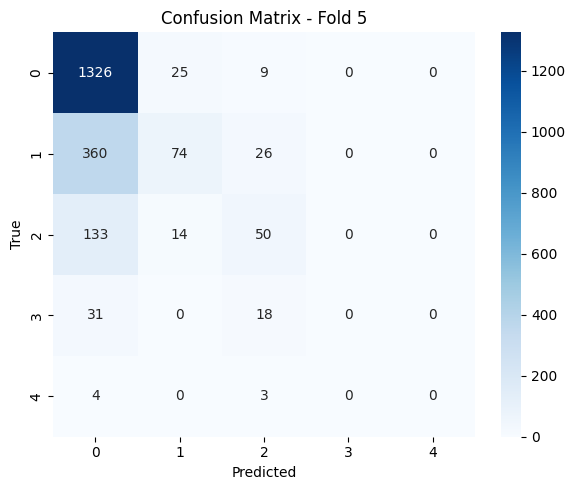

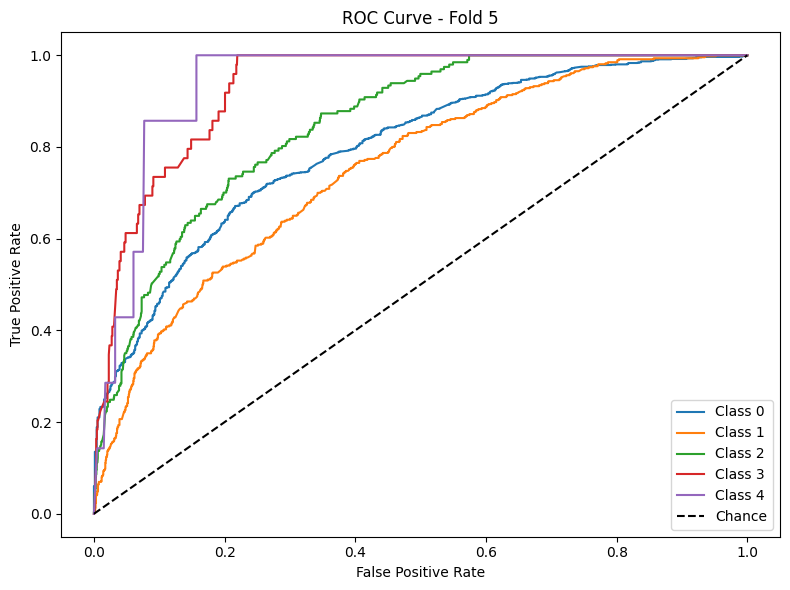


Average Accuracy: 0.6978
Average F1 Macro: 0.3098
Average AUC: 0.8604


======= Training Phase 4 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5778 - loss: 1.5400 - val_accuracy: 0.6413 - val_loss: 0.9830
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6419 - loss: 0.9536 - val_accuracy: 0.6322 - val_loss: 0.9106
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6578 - loss: 0.8483 - val_accuracy: 0.6472 - val_loss: 0.8446
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6580 - loss: 0.8414 - val_accuracy: 0.6693 - val_loss: 0.8287
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6732 - loss: 0.8197 - val_accuracy: 0.6660 - val_loss: 0.8002
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6644 - loss: 0.8157 - val_accuracy: 0.6797 - val_loss: 0.7944
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6691 - loss: 0.7919 - val_accuracy: 0.6680 - val_loss: 0.7971
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6655 - loss: 0.7960 - val_accuracy: 0.6719 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


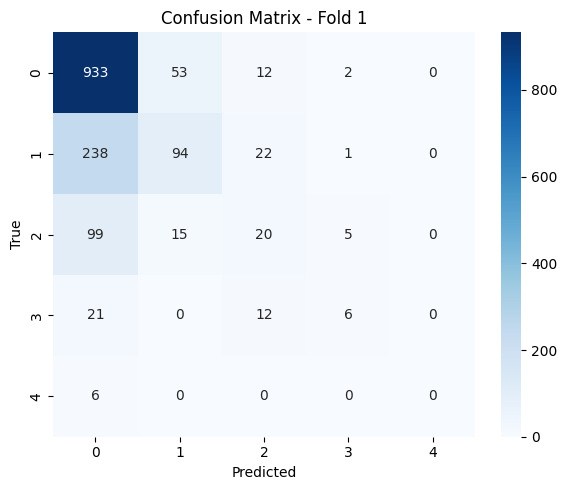

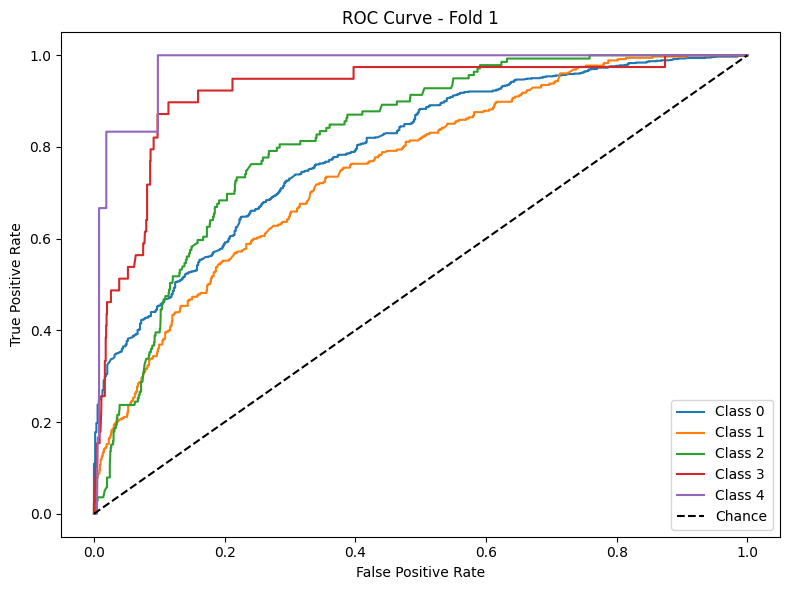

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5992 - loss: 1.5482 - val_accuracy: 0.6478 - val_loss: 0.9890
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6482 - loss: 0.9504 - val_accuracy: 0.6452 - val_loss: 0.8551
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6557 - loss: 0.8819 - val_accuracy: 0.6556 - val_loss: 0.8094
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6495 - loss: 0.8745 - val_accuracy: 0.6706 - val_loss: 0.7936
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6599 - loss: 0.8205 - val_accuracy: 0.6881 - val_loss: 0.7999
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6724 - loss: 0.8094 - val_accuracy: 0.6771 - val_loss: 0.7594
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6673 - loss: 0.8270 - val_accuracy: 0.6888 - val_loss: 0.7588
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6596 - loss: 0.8188 - val_accuracy: 0.6966 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


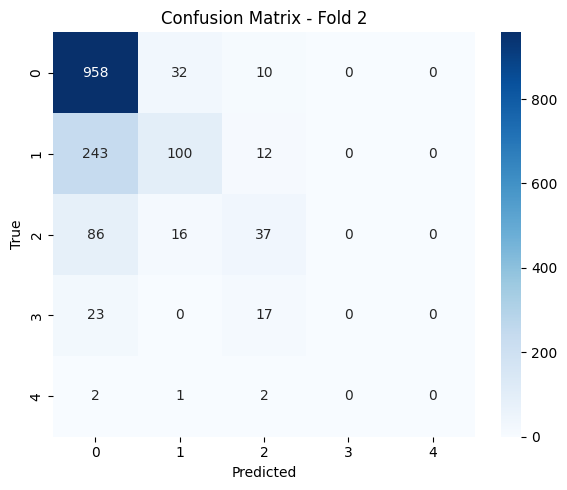

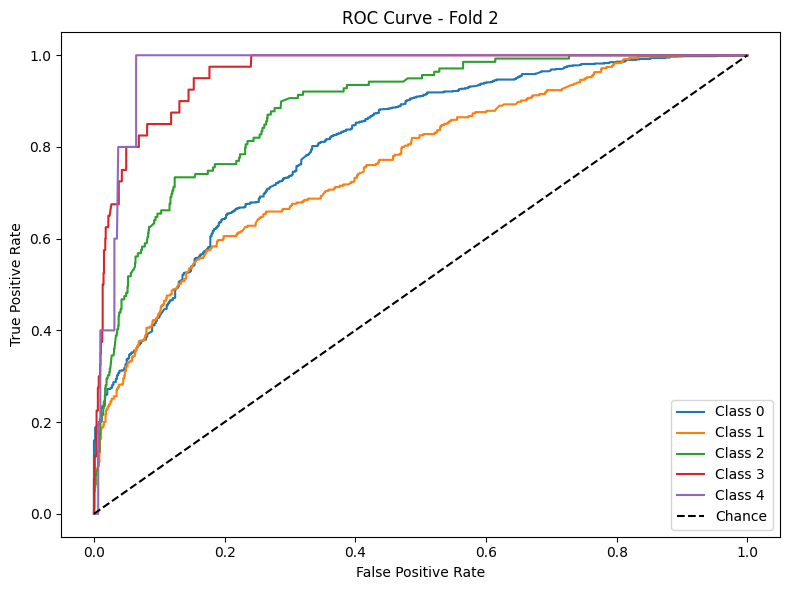

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5843 - loss: 1.5000 - val_accuracy: 0.6517 - val_loss: 1.0095
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6405 - loss: 0.9417 - val_accuracy: 0.6498 - val_loss: 0.8940
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6581 - loss: 0.8964 - val_accuracy: 0.6595 - val_loss: 0.8443
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6595 - loss: 0.8509 - val_accuracy: 0.6667 - val_loss: 0.8231
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6664 - loss: 0.8440 - val_accuracy: 0.6667 - val_loss: 0.7848
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6618 - loss: 0.8441 - val_accuracy: 0.6816 - val_loss: 0.7587
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6662 - loss: 0.8052 - val_accuracy: 0.6673 - val_loss: 0.7814
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6678 - loss: 0.8073 - val_accuracy: 0.6816 - val

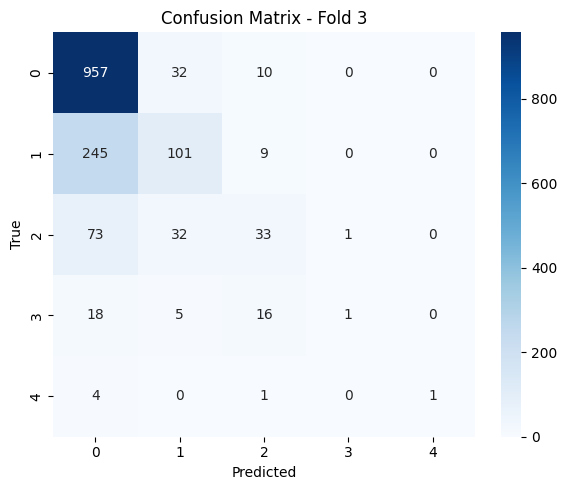

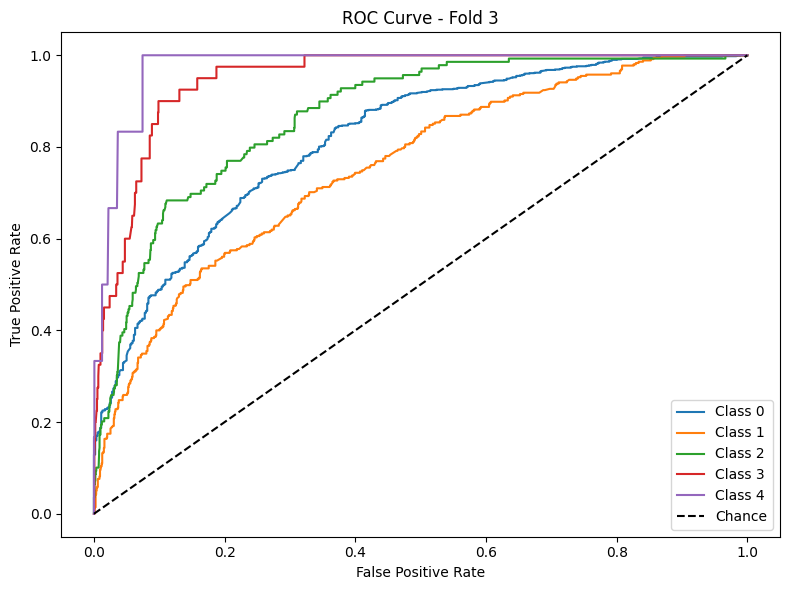

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5994 - loss: 1.5156 - val_accuracy: 0.6586 - val_loss: 0.9506
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6495 - loss: 0.9425 - val_accuracy: 0.6450 - val_loss: 0.8595
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6550 - loss: 0.8717 - val_accuracy: 0.6476 - val_loss: 0.8404
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6516 - loss: 0.8665 - val_accuracy: 0.6834 - val_loss: 0.7895
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6663 - loss: 0.8413 - val_accuracy: 0.6834 - val_loss: 0.7835
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6587 - loss: 0.8452 - val_accuracy: 0.6710 - val_loss: 0.7672
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6650 - loss: 0.8091 - val_accuracy: 0.6853 - val_loss: 0.7608
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6666 - loss: 0.8110 - val_accuracy: 0.6834 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


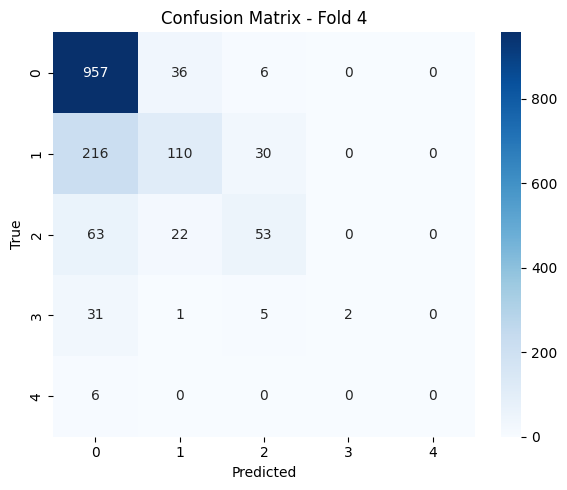

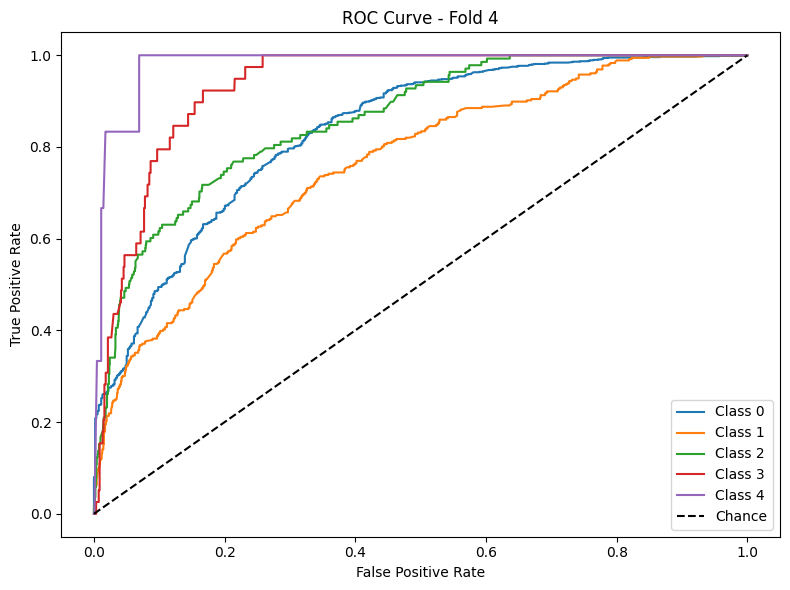

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5901 - loss: 1.6164 - val_accuracy: 0.6482 - val_loss: 0.9871
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6422 - loss: 0.9447 - val_accuracy: 0.6697 - val_loss: 0.9122
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6674 - loss: 0.8503 - val_accuracy: 0.6495 - val_loss: 0.8071
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6703 - loss: 0.8586 - val_accuracy: 0.6795 - val_loss: 0.8028
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6641 - loss: 0.8261 - val_accuracy: 0.6814 - val_loss: 0.7606
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6828 - loss: 0.8010 - val_accuracy: 0.6873 - val_loss: 0.7592
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6669 - loss: 0.8128 - val_accuracy: 0.6944 - val_loss: 0.7408
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6811 - loss: 0.7807 - val_accuracy: 0.6873 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


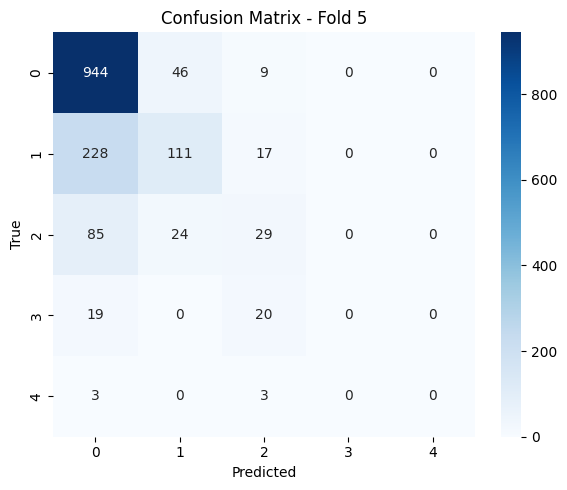

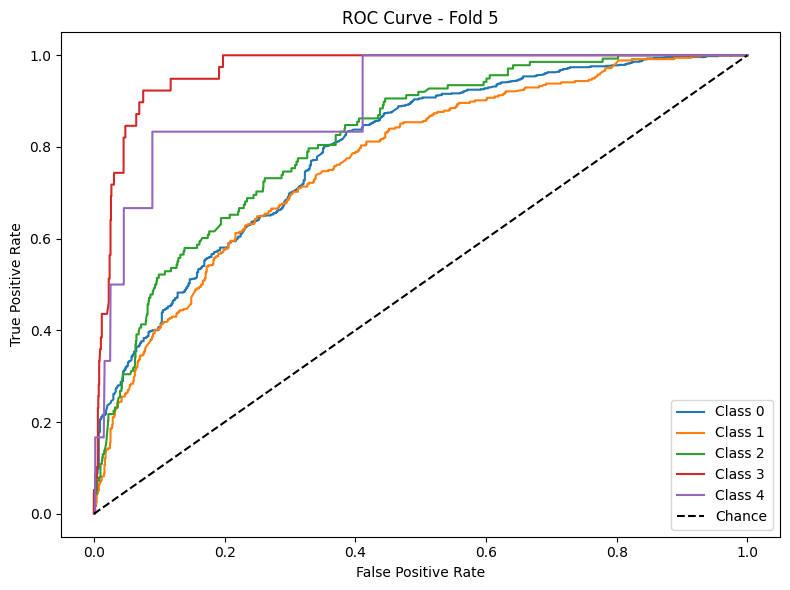


Average Accuracy: 0.7080
Average F1 Macro: 0.3344
Average AUC: 0.8651


In [5]:
# TRAINING ALL PHASES (NO SMOTE)
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"
    
    # Save CNN model (.keras) and scaler
    model.save(f"best_model_{temp}_phase{i}.keras")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics

## Predict on Test Data

In [6]:
def predict_on_test(test_file_path, model_path, scaler_path, school_mapping_file):
    
    # Load model and scaler từ file
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Load dữ liệu test
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    if 'school' in X_test.columns:
        mapping = joblib.load(school_mapping_file)
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    X_test_scaled = scaler.transform(X_test)
    X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)

    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    y_test_bin = to_categorical(y_test)
    auc_score = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       568
           1       0.32      0.38      0.35        63
           2       0.35      0.16      0.22        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.81       698
   macro avg       0.31      0.30      0.30       698
weighted avg       0.77      0.81      0.78       698



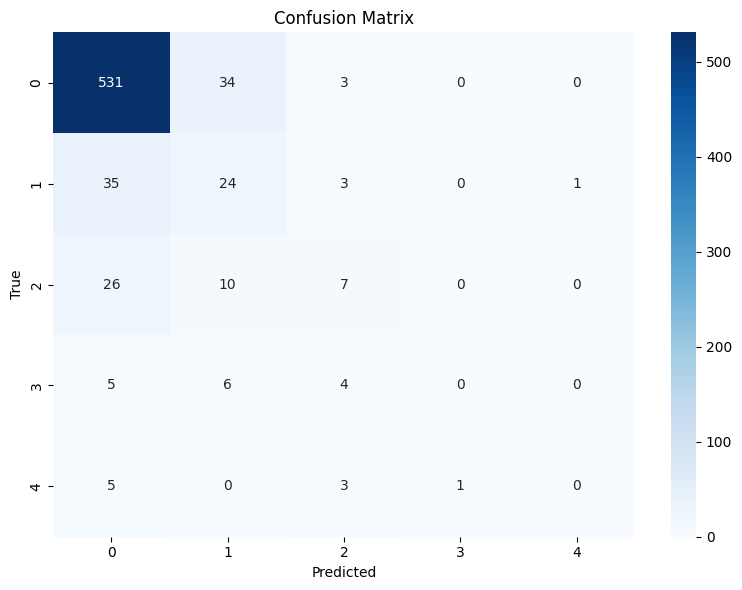


Test AUC (macro-average, OVR): 0.8034


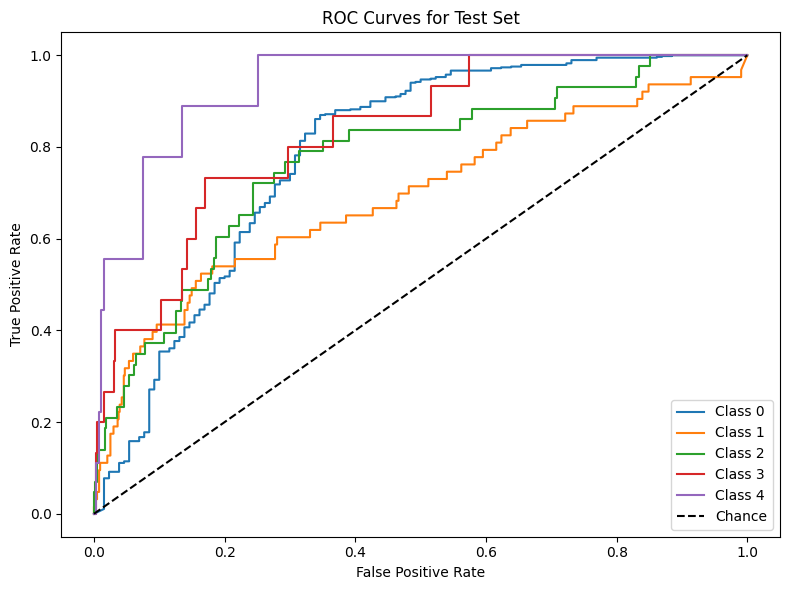

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       544
           1       0.35      0.15      0.21        59
           2       0.42      0.26      0.32        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.83       668
   macro avg       0.33      0.28      0.29       668
weighted avg       0.76      0.83      0.79       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


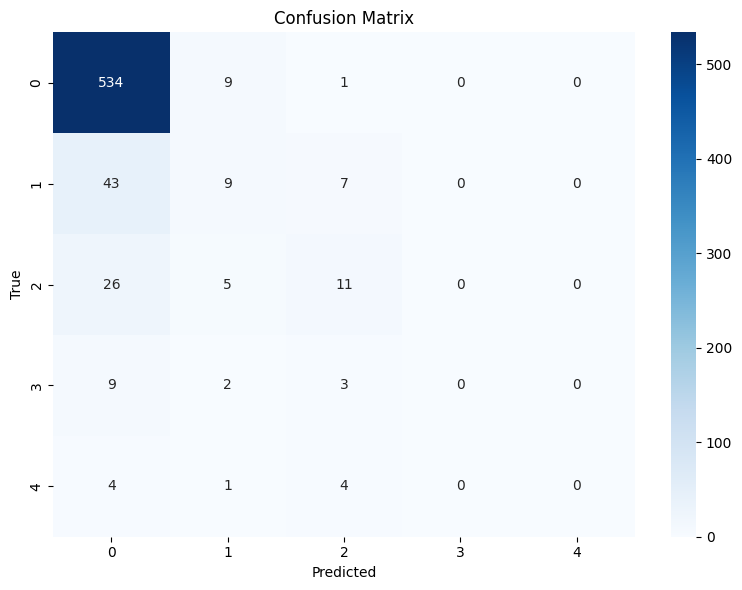


Test AUC (macro-average, OVR): 0.8330


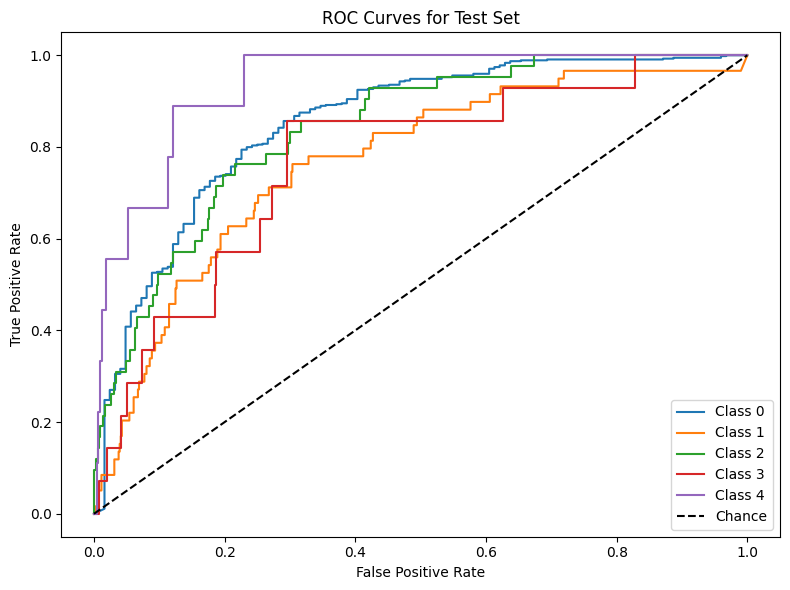

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       455
           1       0.34      0.19      0.25        52
           2       0.45      0.17      0.25        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.33      0.27      0.28       554
weighted avg       0.76      0.82      0.78       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


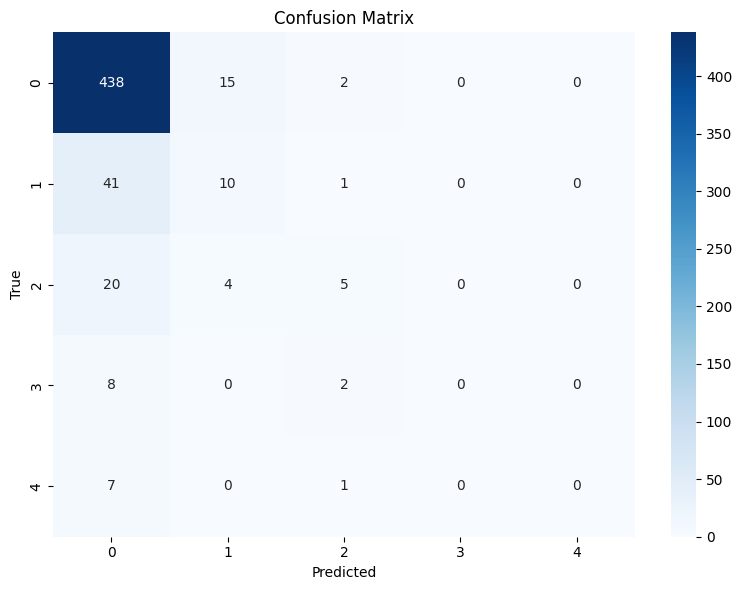


Test AUC (macro-average, OVR): 0.7913


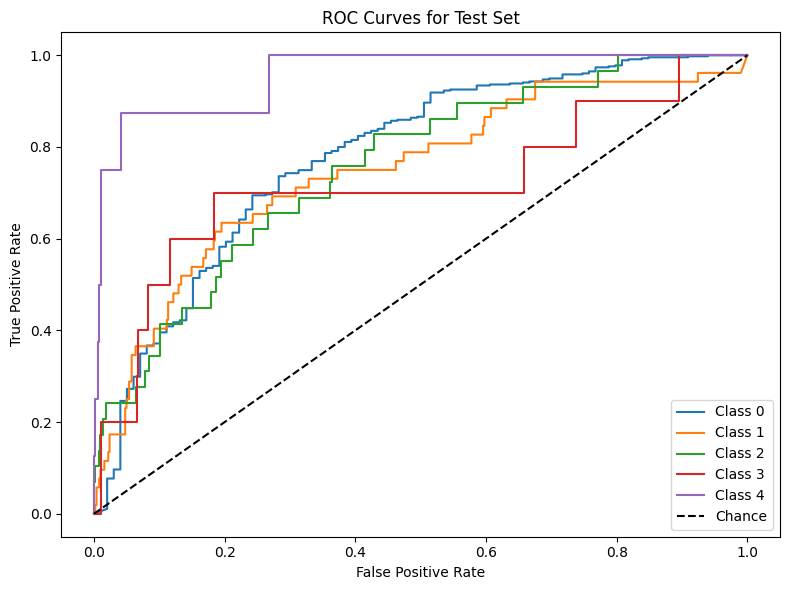

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       395
           1       0.21      0.38      0.27        40
           2       0.27      0.12      0.17        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.76       477
   macro avg       0.27      0.28      0.26       477
weighted avg       0.76      0.76      0.76       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


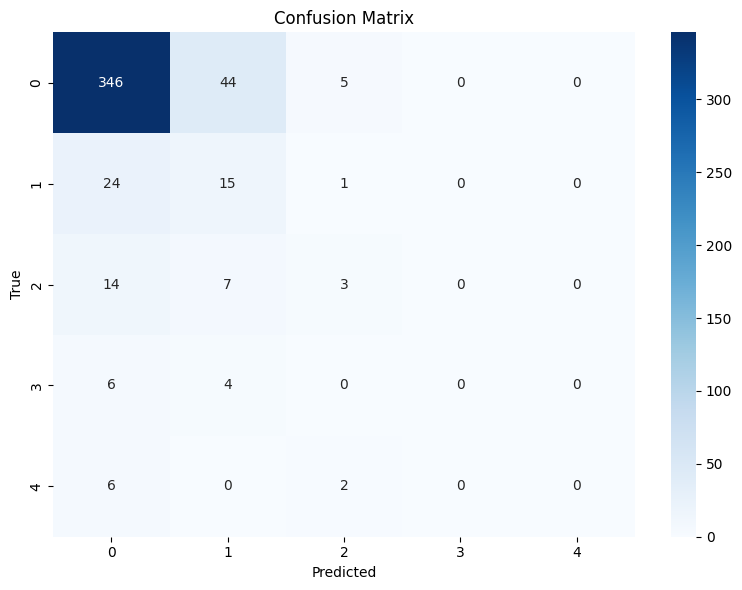


Test AUC (macro-average, OVR): 0.7707


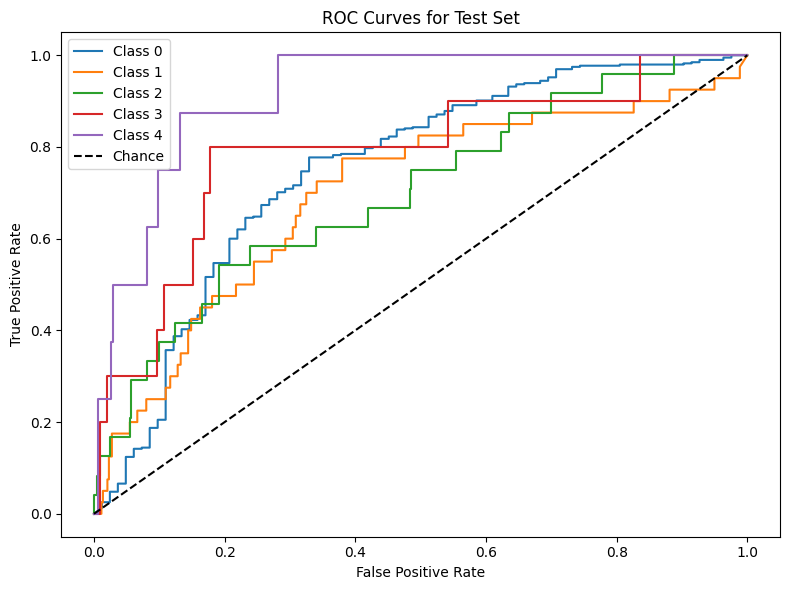

In [7]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Keras model
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.keras'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)

# Sample


=== Training Phase 1 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5039 - loss: 1.3558 - val_accuracy: 0.5145 - val_loss: 1.0264
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6138 - loss: 0.9294 - val_accuracy: 0.5783 - val_loss: 0.9753
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6425 - loss: 0.8711 - val_accuracy: 0.4994 - val_loss: 1.0664
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6453 - loss: 0.8503 - val_accuracy: 0.5621 - val_loss: 1.0252
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6568 - loss: 0.8320 - val_accuracy: 0.5783 - val_loss: 0.9634
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6696 - loss: 0.8104 - val_accuracy: 0.5849 - val_loss: 0.9752
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6678 - loss: 0.8081 - val_accuracy: 0.5580 - val_loss: 0.9981
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6698 - loss: 0.7928 - val_accuracy: 0.5731 - val_

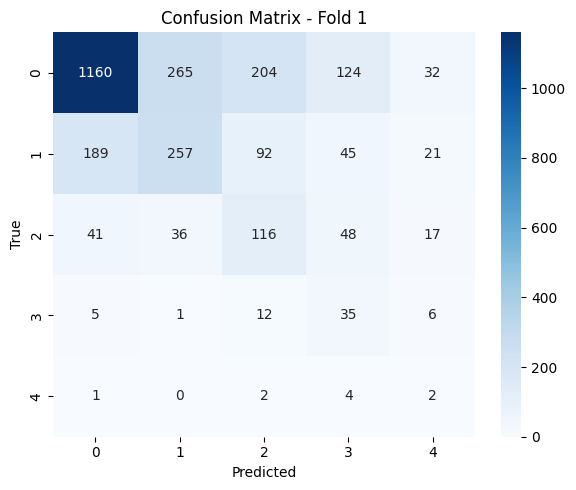

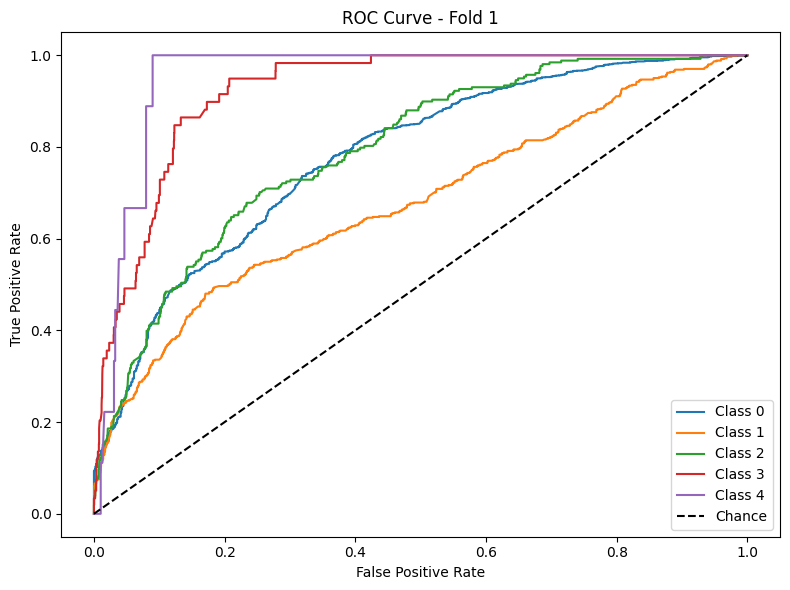

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5064 - loss: 1.3299 - val_accuracy: 0.4550 - val_loss: 1.1323
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6232 - loss: 0.9228 - val_accuracy: 0.5608 - val_loss: 1.0117
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6498 - loss: 0.8658 - val_accuracy: 0.4926 - val_loss: 1.0747
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6564 - loss: 0.8427 - val_accuracy: 0.5645 - val_loss: 1.0228
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6674 - loss: 0.8267 - val_accuracy: 0.5497 - val_loss: 0.9770
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6734 - loss: 0.8181 - val_accuracy: 0.4831 - val_loss: 1.0854
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6738 - loss: 0.8097 - val_accuracy: 0.5586 - val_loss: 1.0032
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6803 - loss: 0.7890 - val_accuracy: 0.5962 - val

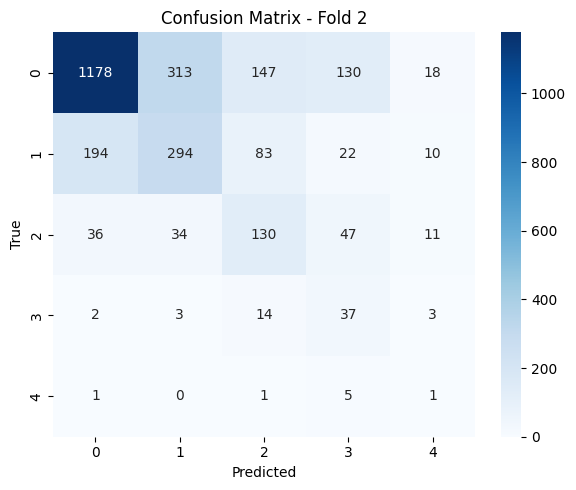

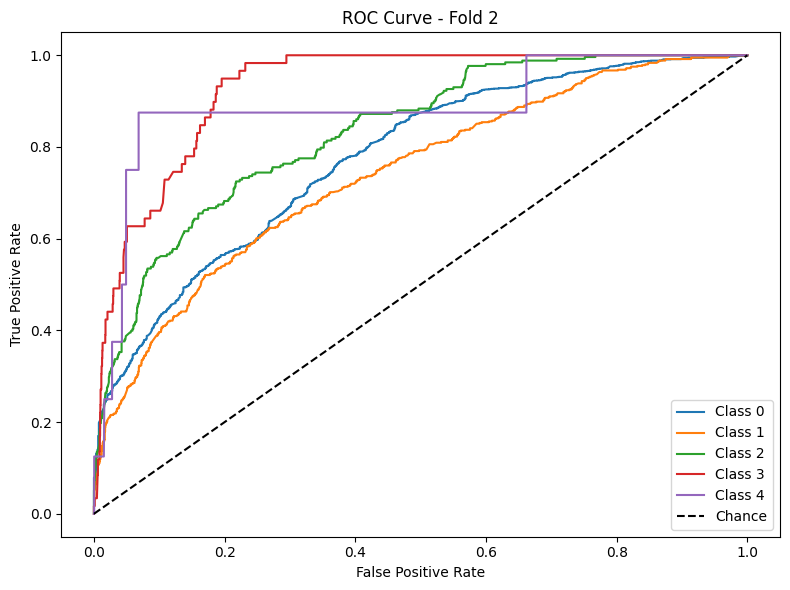

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4907 - loss: 1.3559 - val_accuracy: 0.5111 - val_loss: 1.0597
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6141 - loss: 0.9203 - val_accuracy: 0.5298 - val_loss: 1.0636
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6417 - loss: 0.8664 - val_accuracy: 0.5593 - val_loss: 0.9950
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6506 - loss: 0.8358 - val_accuracy: 0.5733 - val_loss: 0.9513
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6634 - loss: 0.8169 - val_accuracy: 0.5593 - val_loss: 0.9994
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6635 - loss: 0.8129 - val_accuracy: 0.5965 - val_loss: 0.9042
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6737 - loss: 0.7832 - val_accuracy: 0.5601 - val_loss: 0.9913
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6817 - loss: 0.7777 - val_accuracy: 0.5634 - val

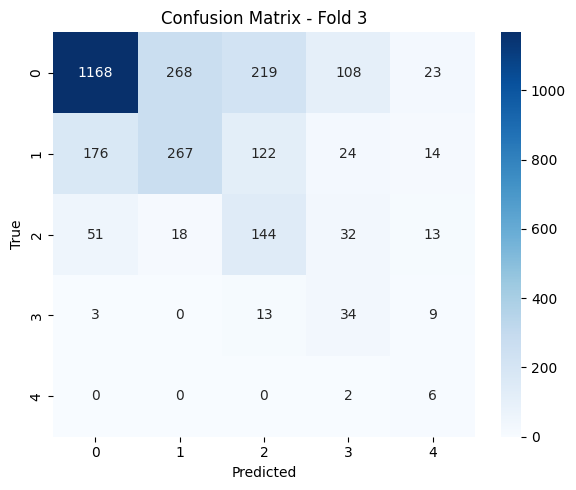

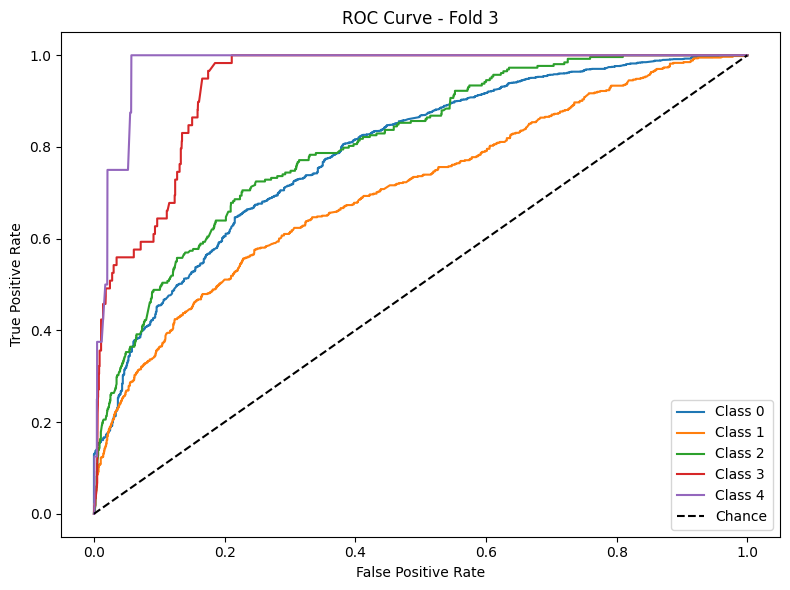

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5148 - loss: 1.2927 - val_accuracy: 0.5645 - val_loss: 0.9998
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6258 - loss: 0.9124 - val_accuracy: 0.5851 - val_loss: 0.9539
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6453 - loss: 0.8526 - val_accuracy: 0.5980 - val_loss: 0.9327
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6533 - loss: 0.8383 - val_accuracy: 0.5866 - val_loss: 0.9409
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6693 - loss: 0.8092 - val_accuracy: 0.5612 - val_loss: 0.9708
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6698 - loss: 0.7961 - val_accuracy: 0.5929 - val_loss: 0.9101
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6759 - loss: 0.7864 - val_accuracy: 0.6161 - val_loss: 0.8805
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6761 - loss: 0.7763 - val_accuracy: 0.6330 - val

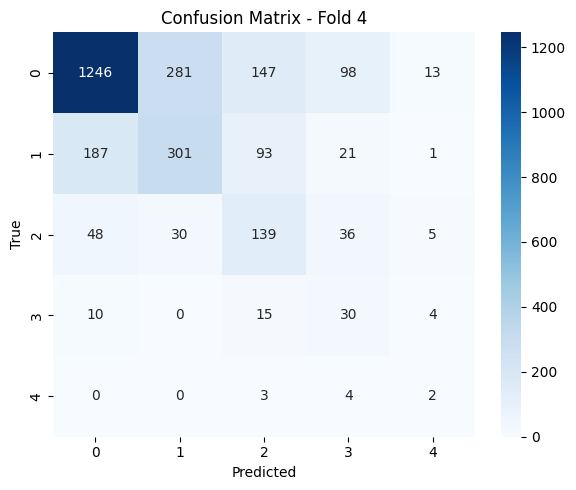

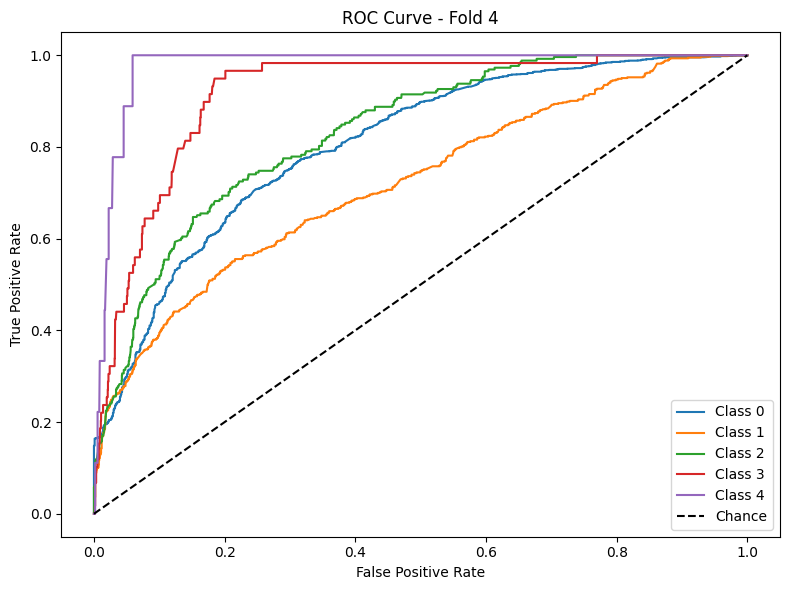

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4869 - loss: 1.3759 - val_accuracy: 0.4838 - val_loss: 1.1107
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6118 - loss: 0.9428 - val_accuracy: 0.4996 - val_loss: 1.1093
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6381 - loss: 0.8866 - val_accuracy: 0.5276 - val_loss: 1.0473
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6583 - loss: 0.8463 - val_accuracy: 0.6102 - val_loss: 0.9180
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6601 - loss: 0.8397 - val_accuracy: 0.5987 - val_loss: 0.9450
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6679 - loss: 0.8228 - val_accuracy: 0.5969 - val_loss: 0.9553
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6747 - loss: 0.8071 - val_accuracy: 0.6135 - val_loss: 0.9215
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6793 - loss: 0.7960 - val_accuracy: 0.5995 - val_

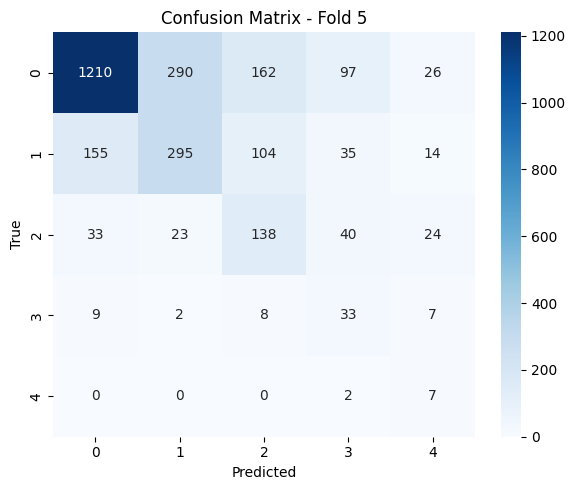

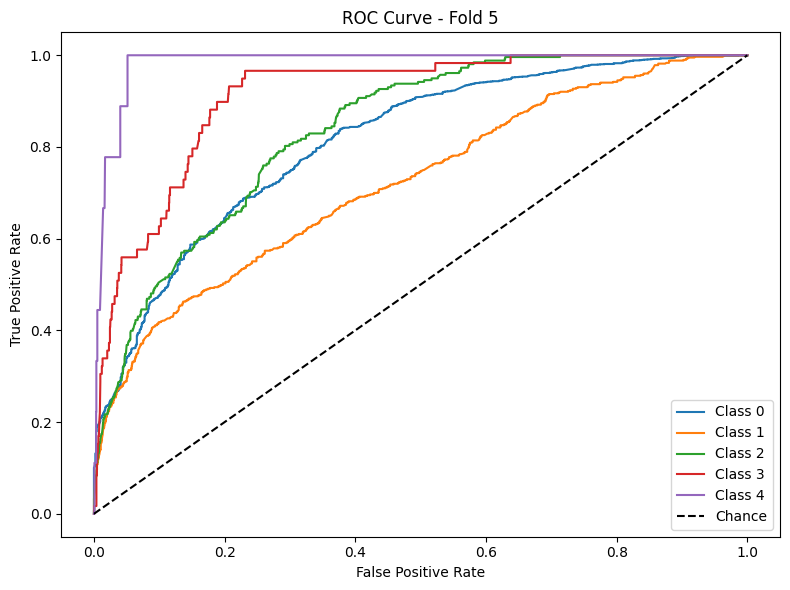


Average Accuracy: 0.6064
Average F1 Macro: 0.3917
Average AUC: 0.8410

=== Training Phase 2 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4916 - loss: 1.4610 - val_accuracy: 0.4996 - val_loss: 1.1276
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6121 - loss: 0.9338 - val_accuracy: 0.5044 - val_loss: 1.0678
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6362 - loss: 0.8777 - val_accuracy: 0.5907 - val_loss: 0.9407
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6530 - loss: 0.8431 - val_accuracy: 0.5788 - val_loss: 0.9961
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6593 - loss: 0.8285 - val_accuracy: 0.6000 - val_loss: 0.9177
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6608 - loss: 0.8083 - val_accuracy: 0.5876 - val_loss: 0.9438
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6668 - loss: 0.8028 - val_accuracy: 0.6000 - val_loss: 0.9132
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6648 - loss: 0.8116 - val_accuracy: 0.6088 - val

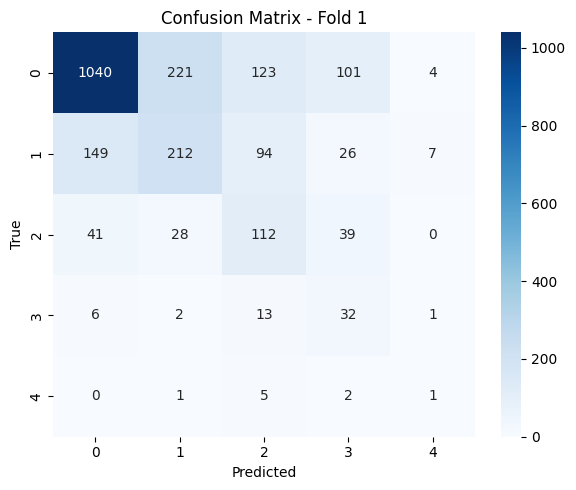

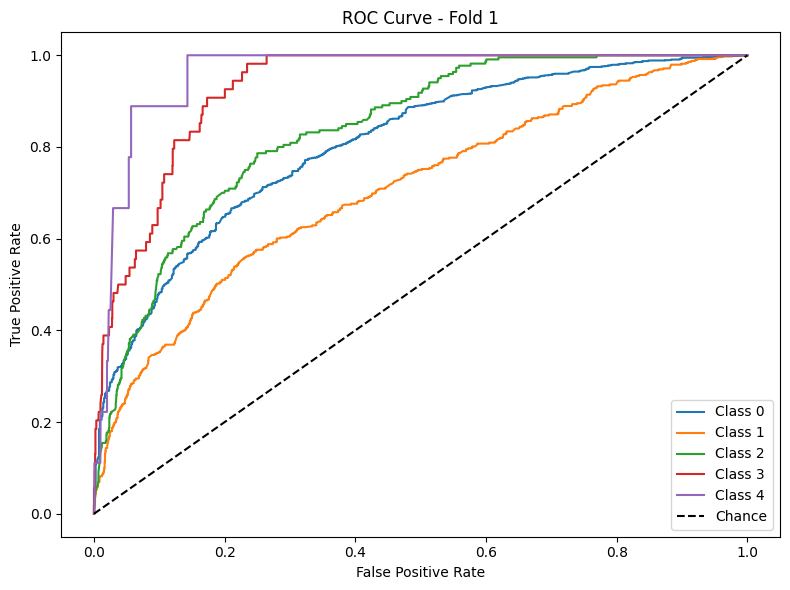

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5153 - loss: 1.3329 - val_accuracy: 0.4173 - val_loss: 1.1809
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6162 - loss: 0.9086 - val_accuracy: 0.5677 - val_loss: 0.9701
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6422 - loss: 0.8482 - val_accuracy: 0.5385 - val_loss: 1.0276
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6614 - loss: 0.8080 - val_accuracy: 0.5575 - val_loss: 0.9620
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6641 - loss: 0.8043 - val_accuracy: 0.6137 - val_loss: 0.9456
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6674 - loss: 0.7928 - val_accuracy: 0.5633 - val_loss: 0.9591
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6710 - loss: 0.7842 - val_accuracy: 0.6040 - val_loss: 0.9165
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6822 - loss: 0.7716 - val_accuracy: 0.6230 - val

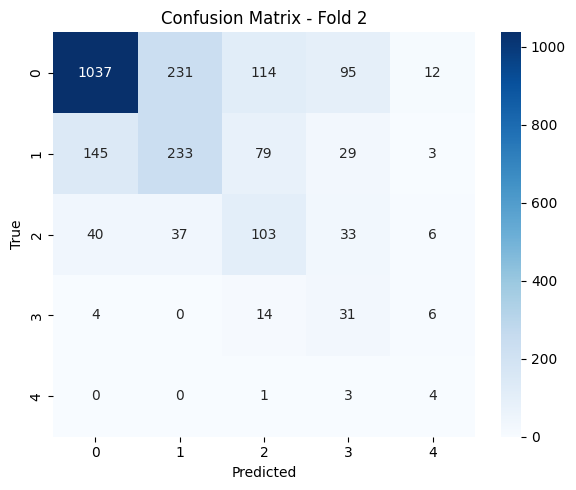

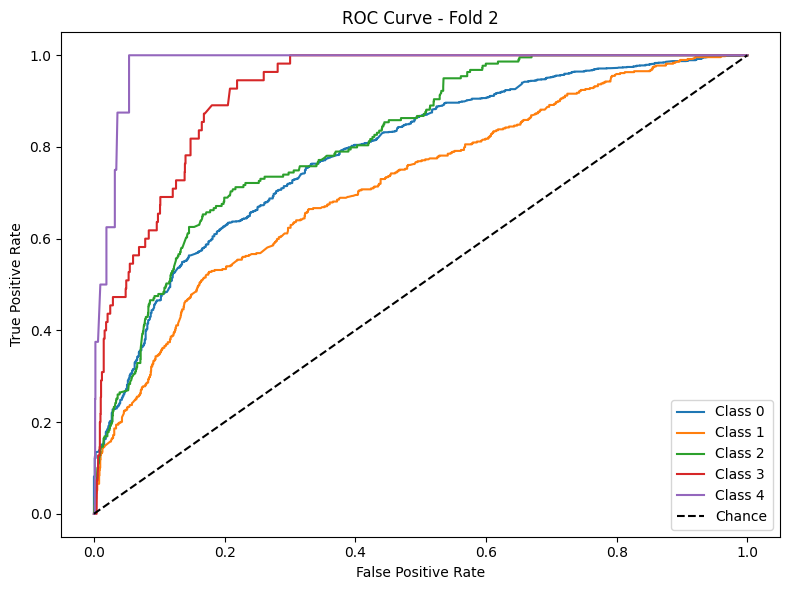

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5022 - loss: 1.4350 - val_accuracy: 0.4595 - val_loss: 1.1151
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6187 - loss: 0.9320 - val_accuracy: 0.4856 - val_loss: 1.1447
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6449 - loss: 0.8670 - val_accuracy: 0.4993 - val_loss: 1.1185
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6469 - loss: 0.8532 - val_accuracy: 0.5122 - val_loss: 1.0829
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6637 - loss: 0.8239 - val_accuracy: 0.5458 - val_loss: 1.0610
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6726 - loss: 0.8103 - val_accuracy: 0.5365 - val_loss: 1.0659
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6767 - loss: 0.7883 - val_accuracy: 0.5516 - val_loss: 1.0176
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6809 - loss: 0.7831 - val_accuracy: 0.5569 - val

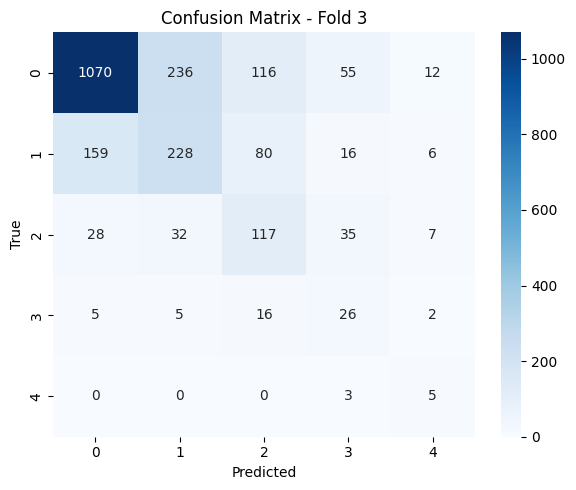

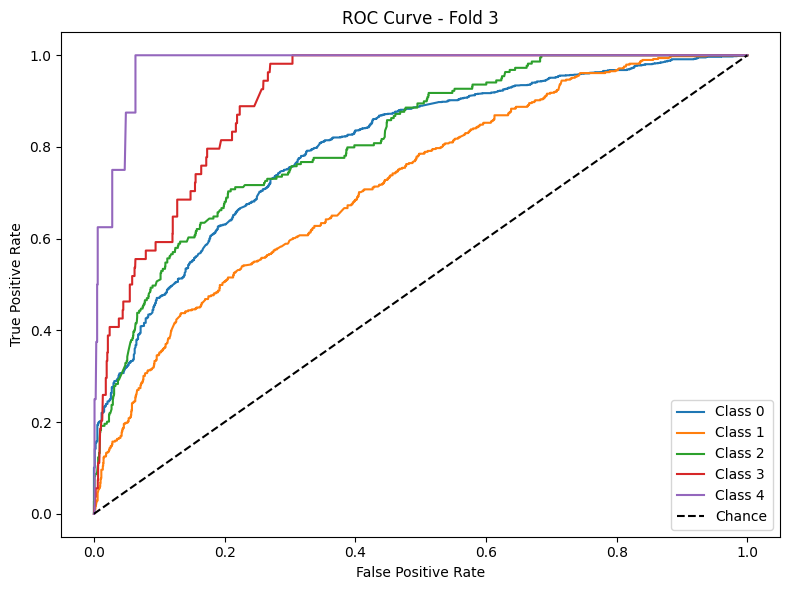

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4981 - loss: 1.4225 - val_accuracy: 0.5091 - val_loss: 1.0408
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6138 - loss: 0.9346 - val_accuracy: 0.4166 - val_loss: 1.1120
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6407 - loss: 0.8775 - val_accuracy: 0.5556 - val_loss: 1.0190
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6568 - loss: 0.8546 - val_accuracy: 0.5631 - val_loss: 0.9717
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6618 - loss: 0.8366 - val_accuracy: 0.6047 - val_loss: 0.9569
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6711 - loss: 0.8151 - val_accuracy: 0.6007 - val_loss: 0.9291
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6733 - loss: 0.8143 - val_accuracy: 0.5919 - val_loss: 0.9312
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6847 - loss: 0.7852 - val_accuracy: 0.5834 - val

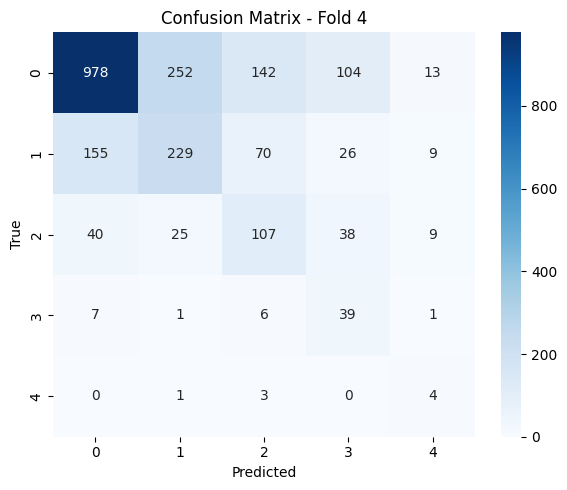

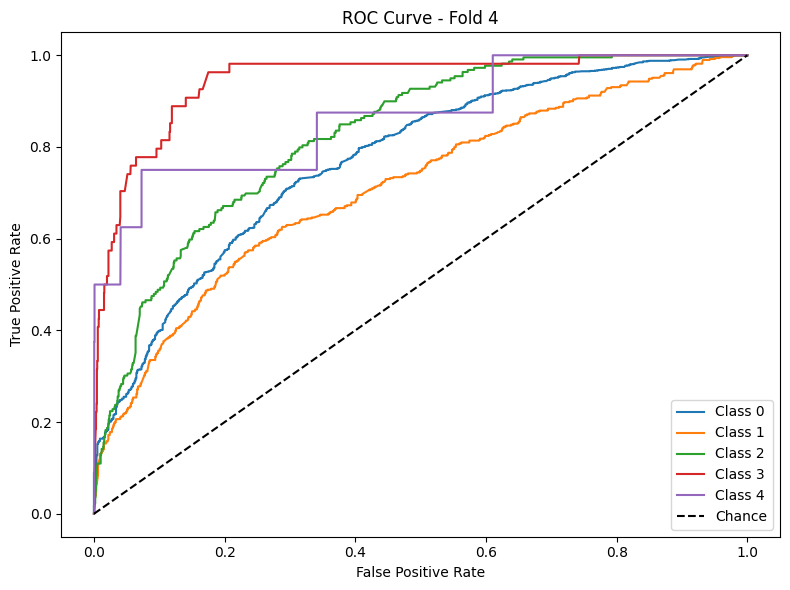

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5080 - loss: 1.4030 - val_accuracy: 0.5374 - val_loss: 1.0440
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6170 - loss: 0.9400 - val_accuracy: 0.5688 - val_loss: 0.9957
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6446 - loss: 0.8655 - val_accuracy: 0.5317 - val_loss: 1.0611
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6576 - loss: 0.8422 - val_accuracy: 0.5489 - val_loss: 0.9791
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6639 - loss: 0.8203 - val_accuracy: 0.5564 - val_loss: 0.9540
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6667 - loss: 0.8276 - val_accuracy: 0.5502 - val_loss: 1.0162
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6722 - loss: 0.8028 - val_accuracy: 0.5803 - val_loss: 0.9733
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6835 - loss: 0.7802 - val_accuracy: 0.5631 - val

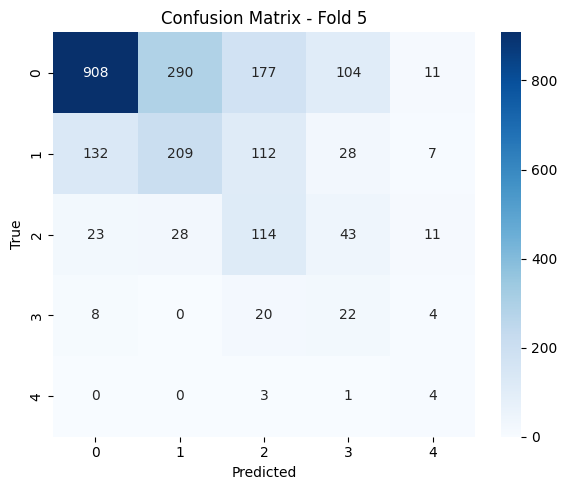

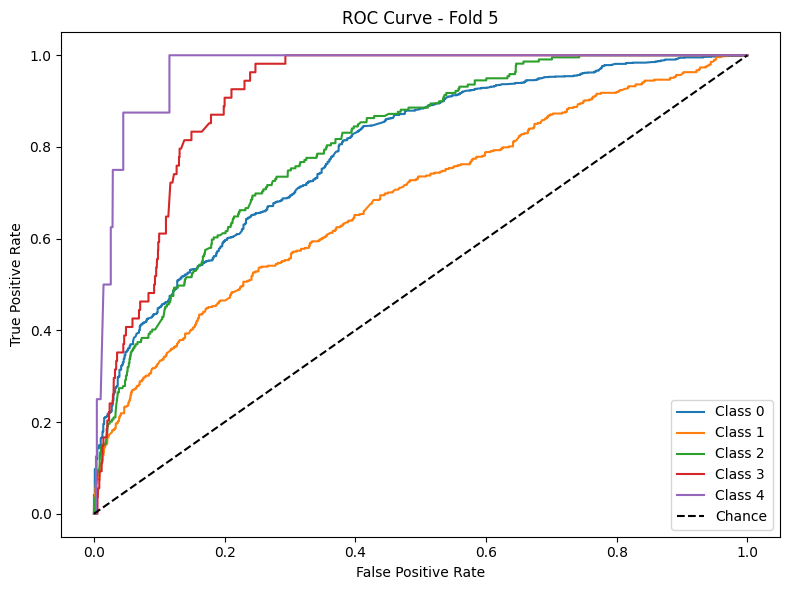


Average Accuracy: 0.6077
Average F1 Macro: 0.4043
Average AUC: 0.8388

=== Training Phase 3 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5086 - loss: 1.4824 - val_accuracy: 0.5063 - val_loss: 1.0763
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6348 - loss: 0.9184 - val_accuracy: 0.5448 - val_loss: 1.0524
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6465 - loss: 0.8710 - val_accuracy: 0.5926 - val_loss: 0.9887
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6627 - loss: 0.8337 - val_accuracy: 0.5540 - val_loss: 1.0707
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6788 - loss: 0.8148 - val_accuracy: 0.6066 - val_loss: 0.9977
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6773 - loss: 0.8092 - val_accuracy: 0.6128 - val_loss: 0.9514
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6892 - loss: 0.7923 - val_accuracy: 0.5781 - val_loss: 0.9809
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6890 - loss: 0.7756 - val_accuracy: 0.6056 - val

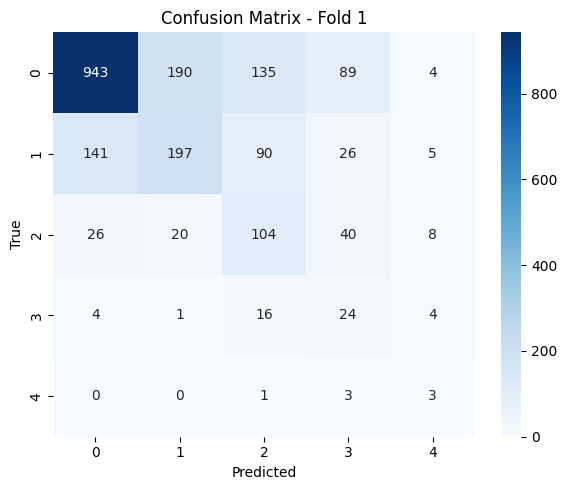

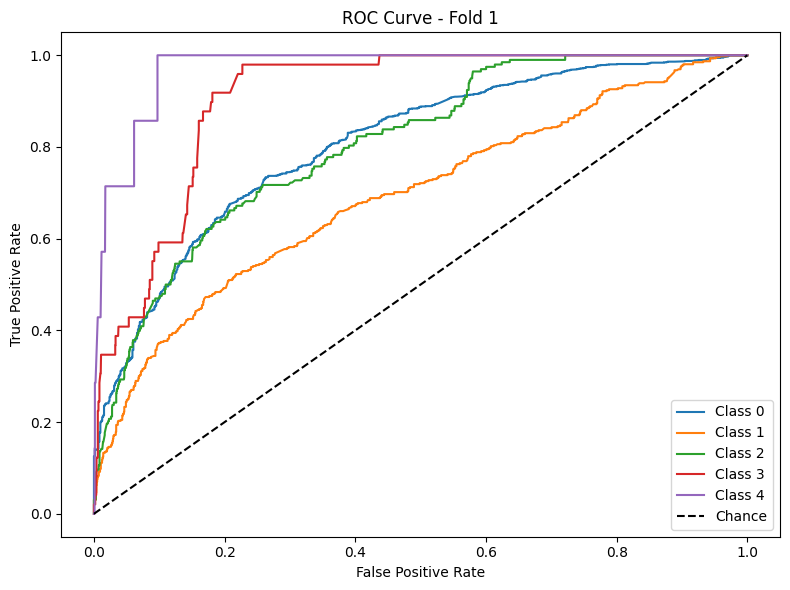

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4997 - loss: 1.5011 - val_accuracy: 0.4031 - val_loss: 1.3543
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6251 - loss: 0.9222 - val_accuracy: 0.5284 - val_loss: 1.0800
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6375 - loss: 0.8787 - val_accuracy: 0.5333 - val_loss: 1.0971
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6623 - loss: 0.8440 - val_accuracy: 0.5289 - val_loss: 0.9918
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6713 - loss: 0.8196 - val_accuracy: 0.5574 - val_loss: 0.9627
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6745 - loss: 0.8069 - val_accuracy: 0.5559 - val_loss: 0.9767
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6835 - loss: 0.8009 - val_accuracy: 0.5497 - val_loss: 1.0372
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6882 - loss: 0.7862 - val_accuracy: 0.5661 - val

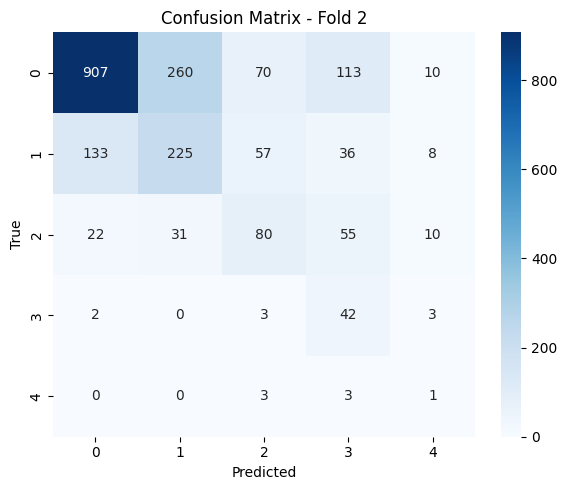

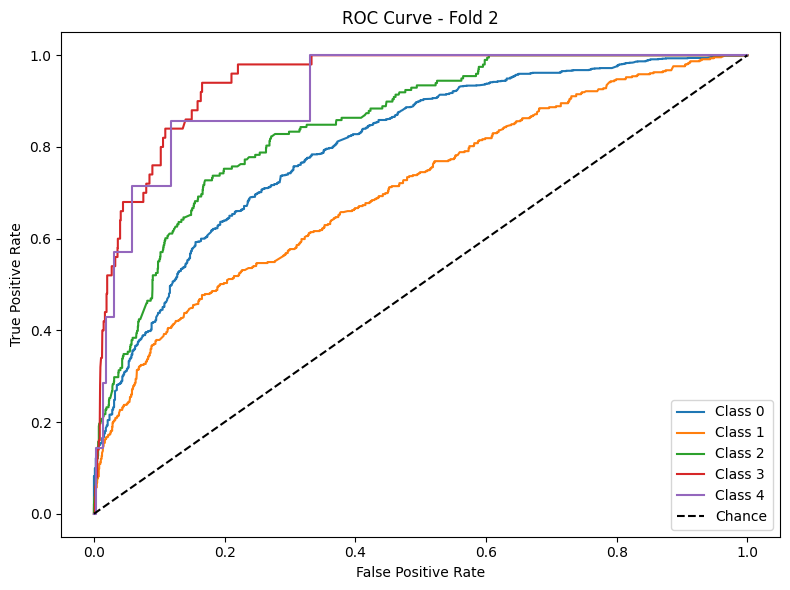

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4982 - loss: 1.4839 - val_accuracy: 0.5014 - val_loss: 1.0745
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6141 - loss: 0.9430 - val_accuracy: 0.5188 - val_loss: 1.0777
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6398 - loss: 0.8872 - val_accuracy: 0.5342 - val_loss: 1.0122
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6487 - loss: 0.8600 - val_accuracy: 0.5053 - val_loss: 1.0375
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6661 - loss: 0.8273 - val_accuracy: 0.5820 - val_loss: 0.9646
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6638 - loss: 0.8281 - val_accuracy: 0.5805 - val_loss: 0.9517
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6738 - loss: 0.8001 - val_accuracy: 0.5984 - val_loss: 0.9597
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6807 - loss: 0.7864 - val_accuracy: 0.6263 - val

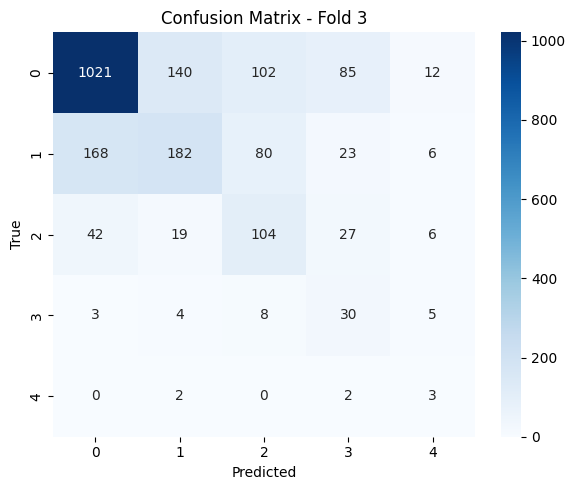

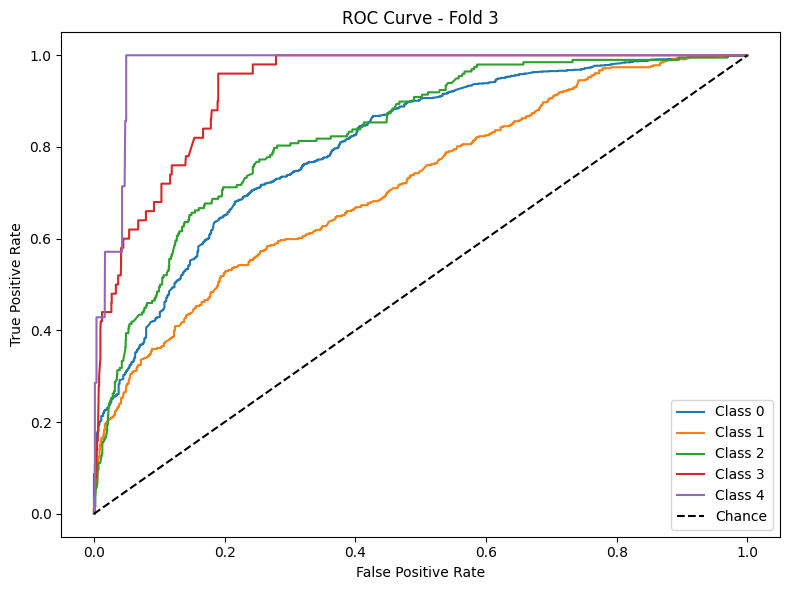

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4942 - loss: 1.5511 - val_accuracy: 0.4928 - val_loss: 1.0240
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6201 - loss: 0.9416 - val_accuracy: 0.5116 - val_loss: 1.0745
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6482 - loss: 0.8821 - val_accuracy: 0.5217 - val_loss: 1.0273
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6674 - loss: 0.8480 - val_accuracy: 0.5998 - val_loss: 0.9661
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6709 - loss: 0.8248 - val_accuracy: 0.5579 - val_loss: 1.0087
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6799 - loss: 0.7993 - val_accuracy: 0.5902 - val_loss: 0.9563
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6855 - loss: 0.8020 - val_accuracy: 0.6234 - val_loss: 0.8988
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6947 - loss: 0.7676 - val_accuracy: 0.5434 - val

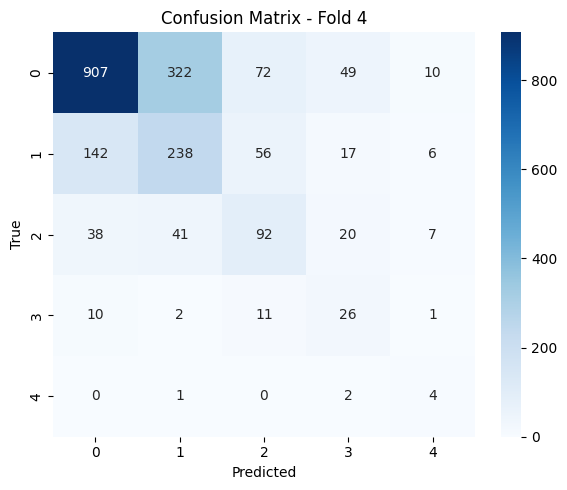

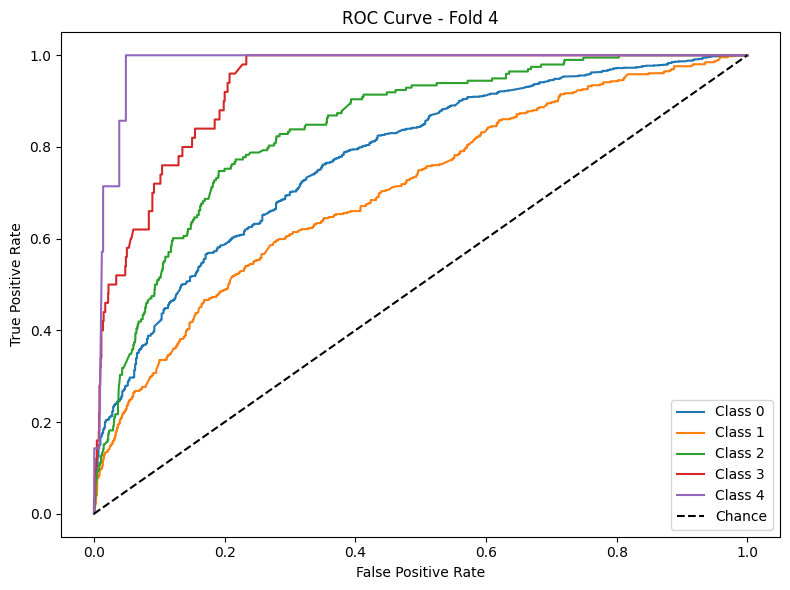

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5288 - loss: 1.4343 - val_accuracy: 0.4848 - val_loss: 1.1305
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6401 - loss: 0.8928 - val_accuracy: 0.5678 - val_loss: 1.0199
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6576 - loss: 0.8257 - val_accuracy: 0.5760 - val_loss: 0.9881
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6753 - loss: 0.8014 - val_accuracy: 0.5924 - val_loss: 1.0042
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6807 - loss: 0.7920 - val_accuracy: 0.5654 - val_loss: 1.0072
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6843 - loss: 0.7818 - val_accuracy: 0.5412 - val_loss: 1.1087
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6833 - loss: 0.7653 - val_accuracy: 0.6131 - val_loss: 0.9342
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6943 - loss: 0.7548 - val_accuracy: 0.6011 - val

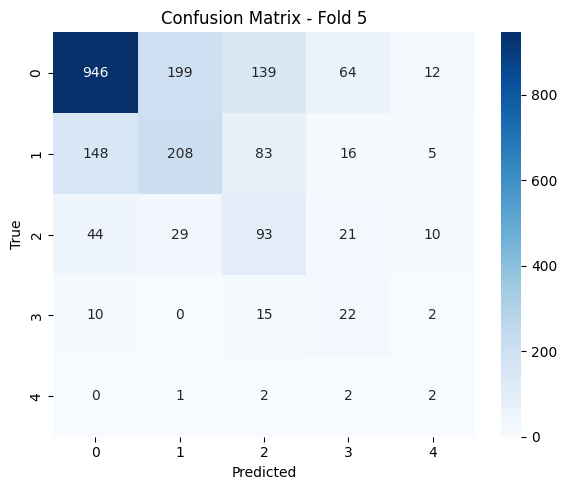

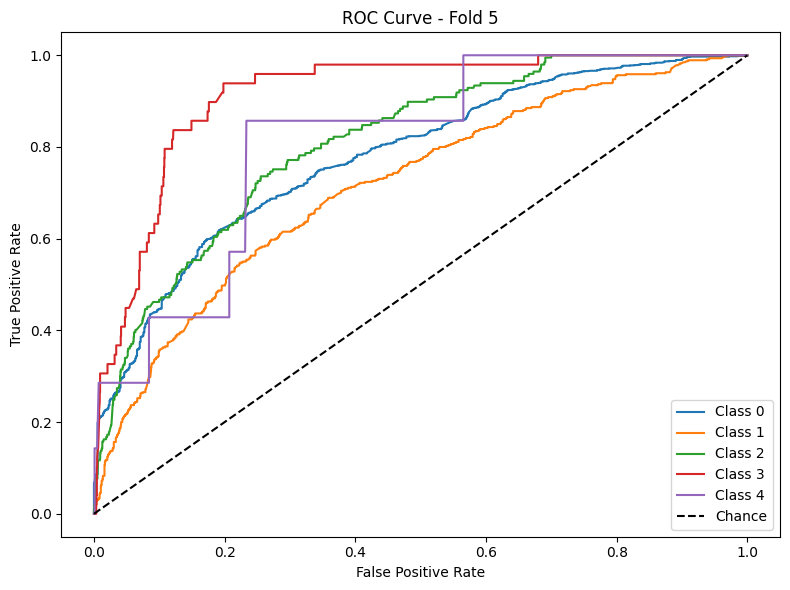


Average Accuracy: 0.6176
Average F1 Macro: 0.4045
Average AUC: 0.8373

=== Training Phase 4 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5203 - loss: 1.4584 - val_accuracy: 0.3762 - val_loss: 1.2180
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6446 - loss: 0.9075 - val_accuracy: 0.5647 - val_loss: 1.0844
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6655 - loss: 0.8406 - val_accuracy: 0.5562 - val_loss: 1.0737
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6842 - loss: 0.8020 - val_accuracy: 0.5036 - val_loss: 1.1432
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6874 - loss: 0.7850 - val_accuracy: 0.5263 - val_loss: 1.1563
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6911 - loss: 0.7669 - val_accuracy: 0.5166 - val_loss: 1.1201
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7002 - loss: 0.7467 - val_accuracy: 0.5796 - val_loss: 1.0296
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7095 - loss: 0.7231 - val_accuracy: 0.5146 - va

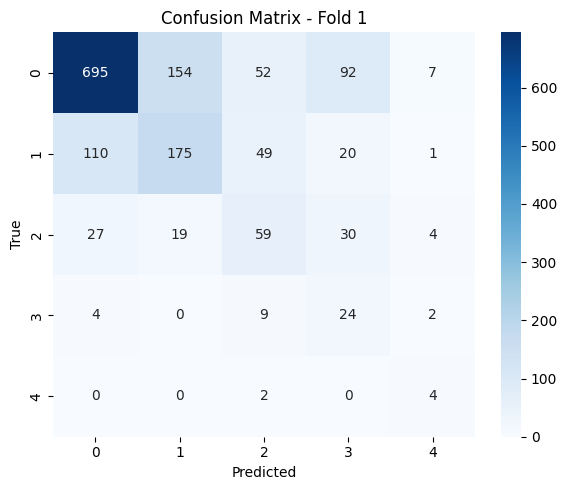

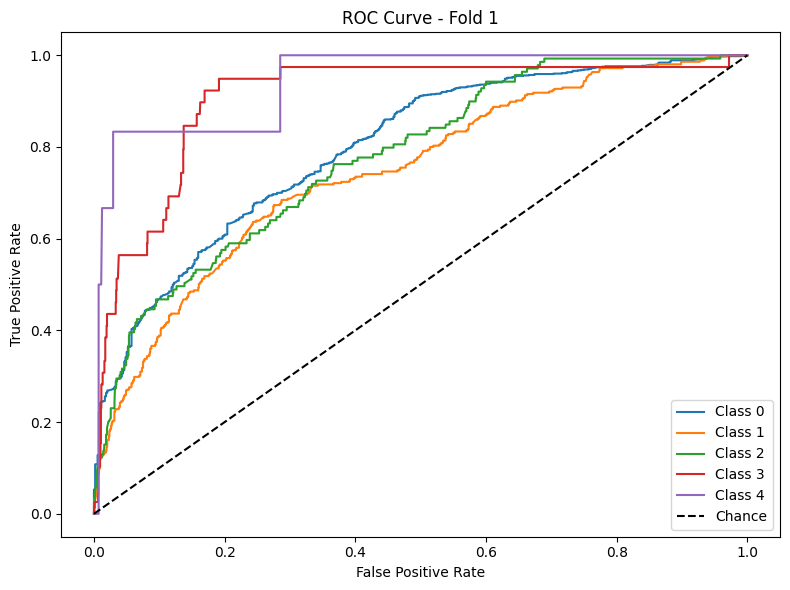

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5259 - loss: 1.5139 - val_accuracy: 0.4412 - val_loss: 1.1182
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6565 - loss: 0.8858 - val_accuracy: 0.5530 - val_loss: 1.0872
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6684 - loss: 0.8159 - val_accuracy: 0.5556 - val_loss: 1.0794
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6873 - loss: 0.7849 - val_accuracy: 0.6257 - val_loss: 0.9311
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6975 - loss: 0.7516 - val_accuracy: 0.5763 - val_loss: 1.0292
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6999 - loss: 0.7525 - val_accuracy: 0.5861 - val_loss: 0.9789
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7139 - loss: 0.7311 - val_accuracy: 0.5945 - val_loss: 1.0054
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7155 - loss: 0.7148 - val_accuracy: 0.5699 - va

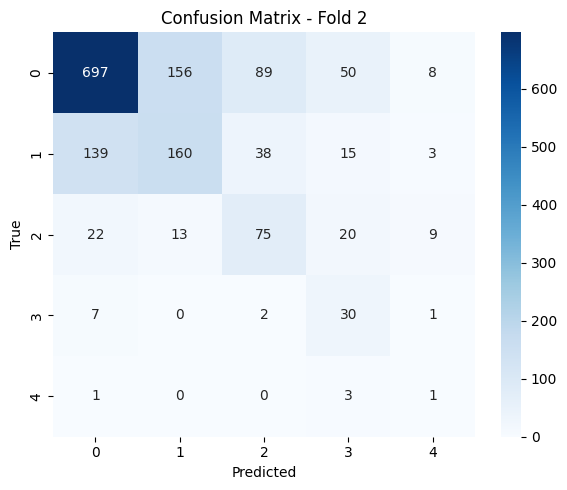

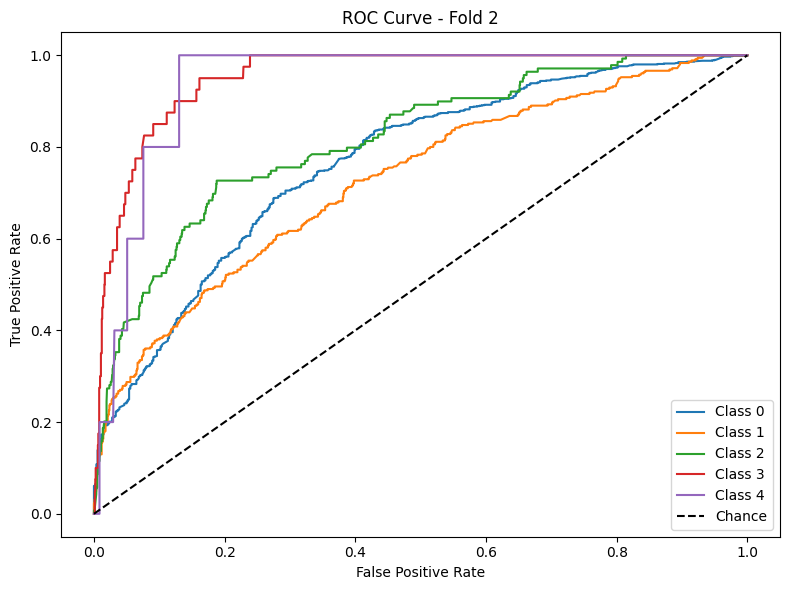

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5196 - loss: 1.5548 - val_accuracy: 0.5575 - val_loss: 1.0825
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6432 - loss: 0.8982 - val_accuracy: 0.5536 - val_loss: 0.9896
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6751 - loss: 0.8215 - val_accuracy: 0.5419 - val_loss: 1.0464
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6861 - loss: 0.7863 - val_accuracy: 0.6114 - val_loss: 0.9537
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7024 - loss: 0.7517 - val_accuracy: 0.6270 - val_loss: 0.9107
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7057 - loss: 0.7572 - val_accuracy: 0.5159 - val_loss: 1.0674
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7060 - loss: 0.7365 - val_accuracy: 0.5809 - val_loss: 0.9723
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7124 - loss: 0.7209 - val_accuracy: 0.5640 - va

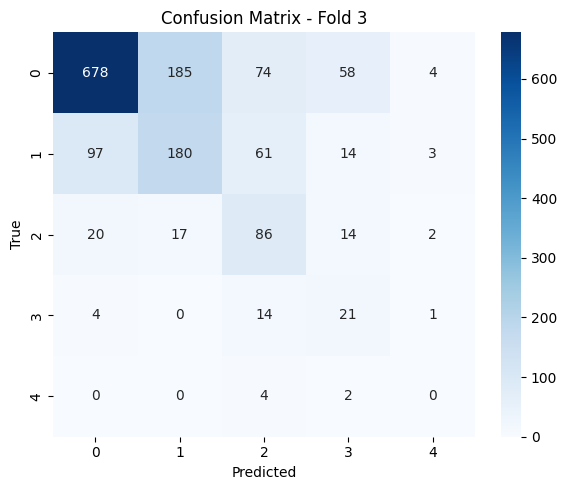

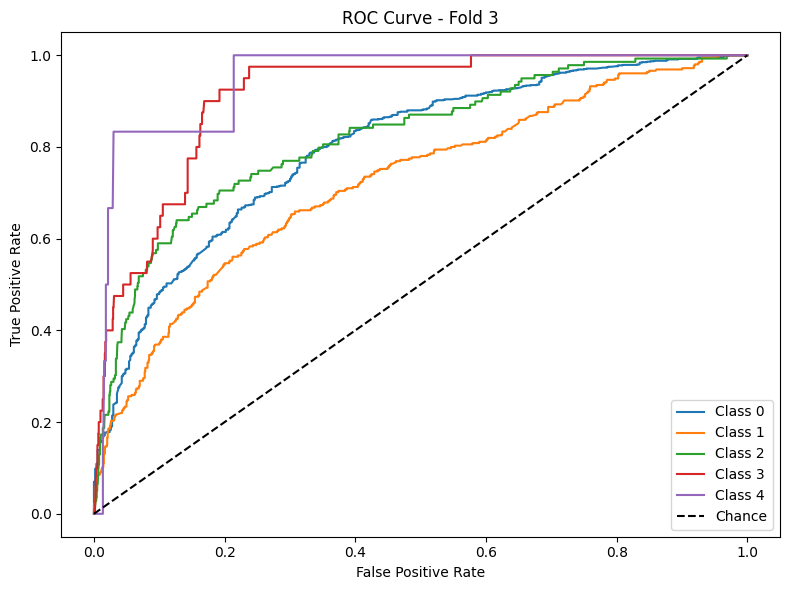

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5293 - loss: 1.4512 - val_accuracy: 0.4402 - val_loss: 1.2274
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6557 - loss: 0.8989 - val_accuracy: 0.5390 - val_loss: 1.0859
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6775 - loss: 0.8193 - val_accuracy: 0.5878 - val_loss: 1.0068
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6954 - loss: 0.7730 - val_accuracy: 0.5962 - val_loss: 0.9516
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6986 - loss: 0.7715 - val_accuracy: 0.6014 - val_loss: 0.9982
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7113 - loss: 0.7513 - val_accuracy: 0.6463 - val_loss: 0.9101
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7092 - loss: 0.7455 - val_accuracy: 0.6001 - val_loss: 0.9319
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7139 - loss: 0.7352 - val_accuracy: 0.6346 - va

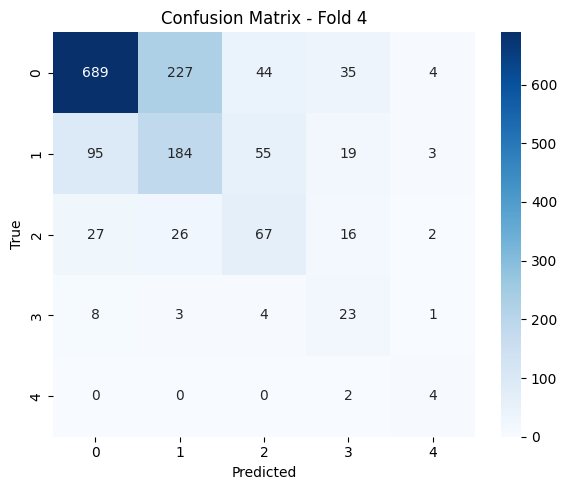

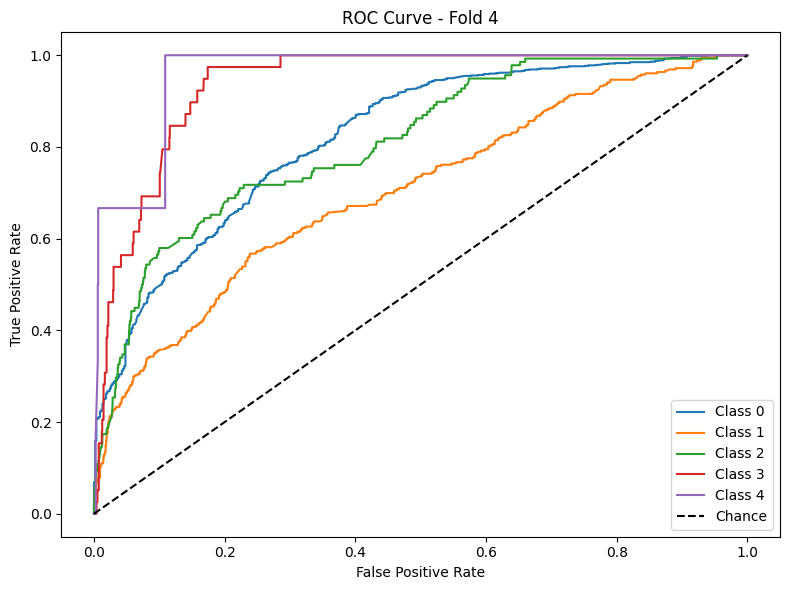

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4939 - loss: 1.5932 - val_accuracy: 0.3843 - val_loss: 1.2360
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6177 - loss: 0.9474 - val_accuracy: 0.4707 - val_loss: 1.2484
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6397 - loss: 0.8663 - val_accuracy: 0.5195 - val_loss: 1.0390
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6561 - loss: 0.8243 - val_accuracy: 0.5800 - val_loss: 0.9885
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6550 - loss: 0.8213 - val_accuracy: 0.5741 - val_loss: 0.9835
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6819 - loss: 0.7710 - val_accuracy: 0.5546 - val_loss: 1.0892
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6823 - loss: 0.7800 - val_accuracy: 0.5943 - val_loss: 0.9876
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6775 - loss: 0.7782 - val_accuracy: 0.5657 - va

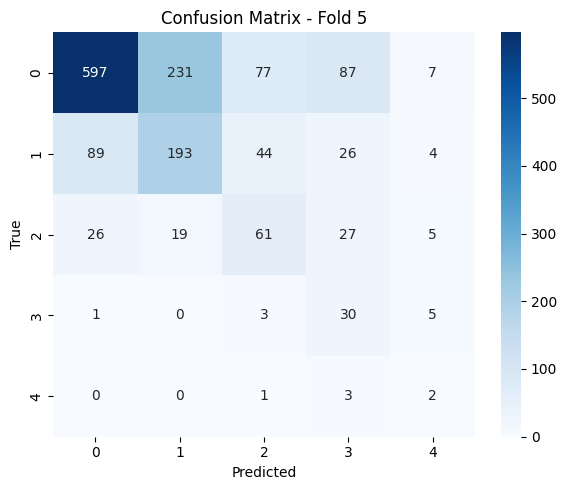

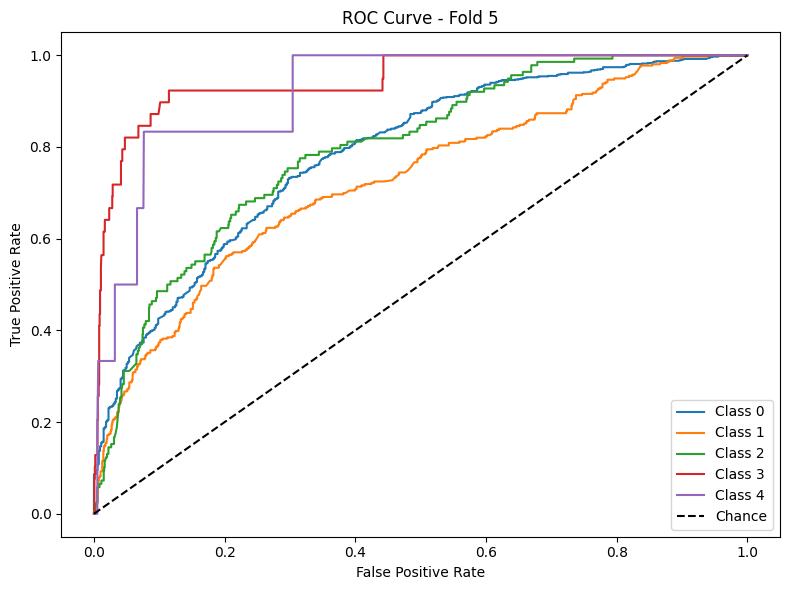


Average Accuracy: 0.6155
Average F1 Macro: 0.4266
Average AUC: 0.8393


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)
    
    temp = "sample" if sample else "no_sample"
    
    model.save(f"best_model_{temp}_phase{i}.keras")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.68      0.79       568
           1       0.13      0.44      0.20        63
           2       0.26      0.37      0.31        43
           3       0.12      0.07      0.09        15
           4       0.00      0.00      0.00         9

    accuracy                           0.62       698
   macro avg       0.29      0.31      0.28       698
weighted avg       0.79      0.62      0.68       698



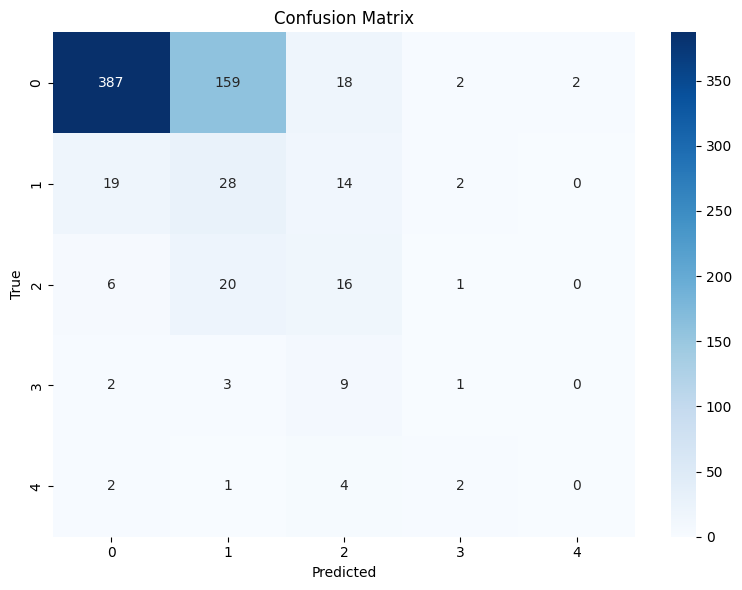


Test AUC (macro-average, OVR): 0.7766


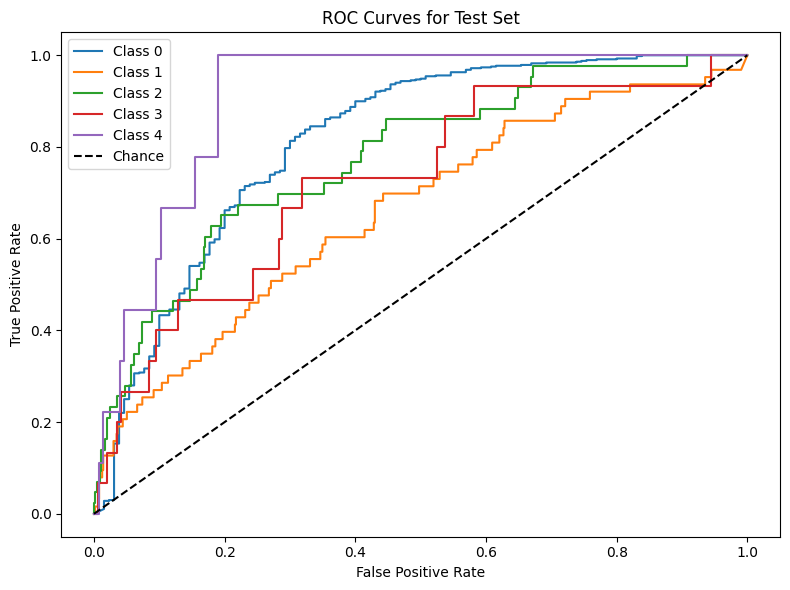

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       544
           1       0.21      0.29      0.24        59
           2       0.28      0.36      0.31        42
           3       0.12      0.07      0.09        14
           4       0.00      0.00      0.00         9

    accuracy                           0.76       668
   macro avg       0.30      0.32      0.31       668
weighted avg       0.77      0.76      0.76       668



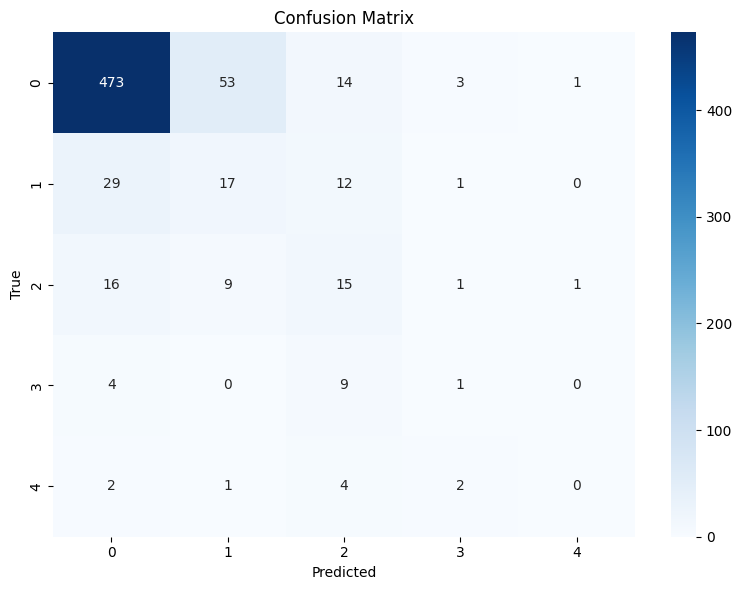


Test AUC (macro-average, OVR): 0.8200


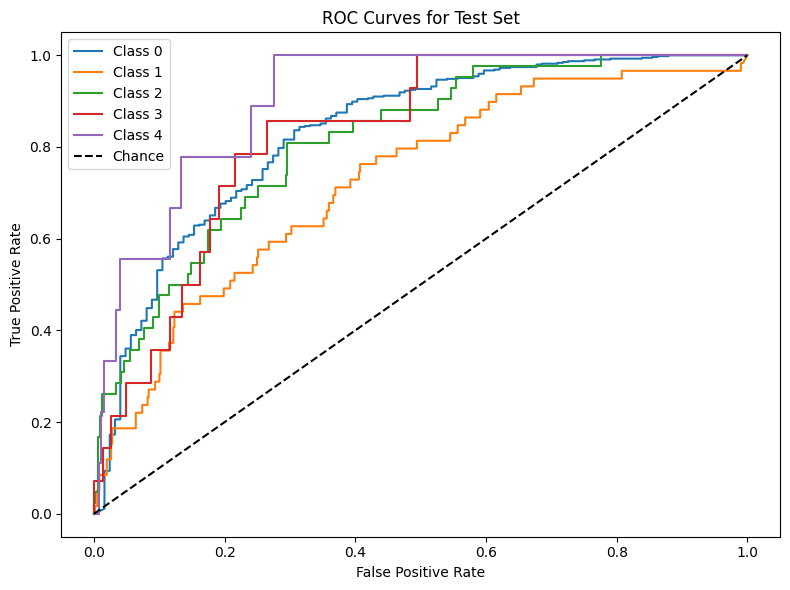

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       455
           1       0.19      0.58      0.29        52
           2       0.15      0.17      0.16        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.65       554
   macro avg       0.25      0.29      0.25       554
weighted avg       0.77      0.65      0.69       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


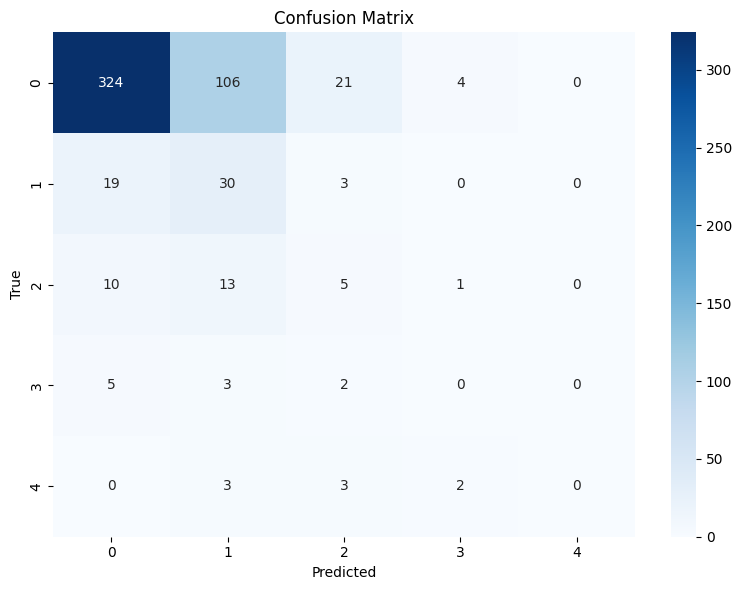


Test AUC (macro-average, OVR): 0.7431


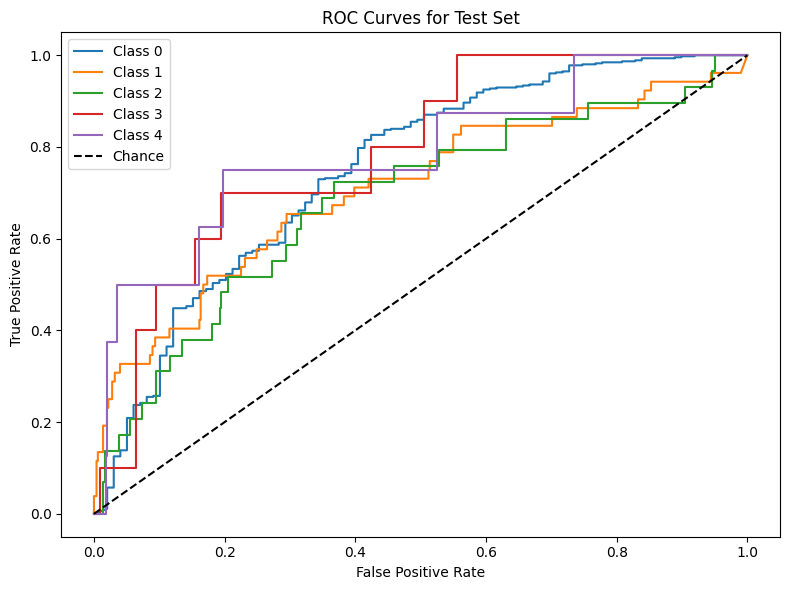

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       395
           1       0.12      0.50      0.19        40
           2       0.14      0.29      0.19        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.55       477
   macro avg       0.23      0.28      0.22       477
weighted avg       0.77      0.55      0.62       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


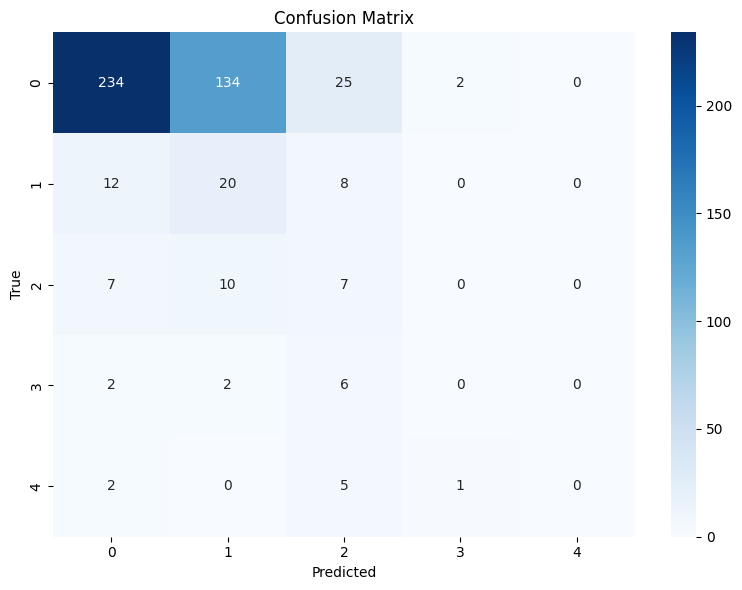


Test AUC (macro-average, OVR): 0.7215


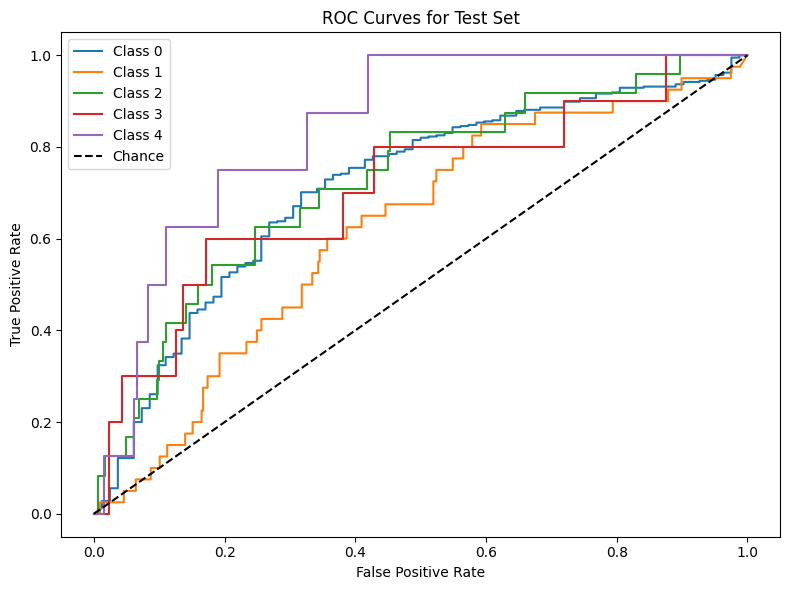

In [9]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Keras model
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.keras'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)